```{eval-rst}
.. include:: sinebow.rst

```

{sinebow27}`Logo`
==================

This is a little cute: Omnipose can "segment" text using the `bact_phase_omni` model. Semantic segmentation of uniform, 
disjoint shapes on a uniform background is absolutely no feat, but it is amusing that a neural network trained purely on
phase contrast images of bacteria gives such reasonable output on something so different from the training set. 
Also, the over-segmentation at cusps hints that the network has learned to pick up on local morphology. 

To make the Omnipose logo/title/favicon, I first generate some rasterized text images with roughly the same mean diameter as the bacteria in my training set: 

In [ ]:
%%capture --no-display 
%load_ext autoreload
%autoreload 2

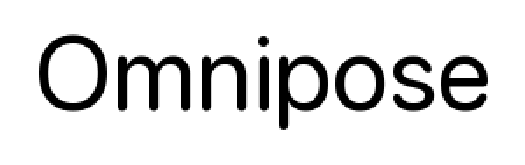

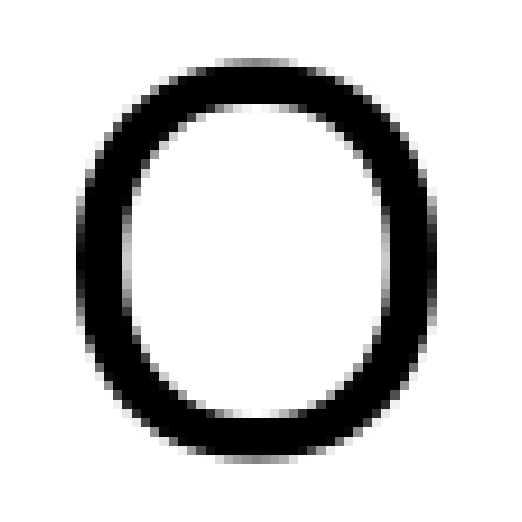

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [ ]:


# Make some text images
import omnipose
omnipose.plot.setup()
from omnipose.plot import imshow
from PIL import Image, ImageDraw, ImageFont
import numpy as np


from omnipose.measure import bbox_to_slice

tsizes = [60]
texts = ["Omnipose","O"]
imgs = []
for textsize in tsizes:
    fonts = [ImageFont.truetype(f, textsize) for f in ["SFNSRounded.ttf"]]
    # fonts = [ImageFont.truetype(f, textsize) for f in ["Arial.ttf"]]
    for text in texts:
        for font in fonts:
            size = np.array([textsize*len(text)*2, textsize*2])
            im = Image.new("RGB", tuple(size), "white")
            d = ImageDraw.Draw(im)
            center = size/2
            anchor = "mm"
            d.text(center, text, fill="black", anchor=anchor, font=font)
            bbox = d.textbbox(center, text, anchor=anchor, font=font)
            bbox = [bbox[1],bbox[0],bbox[3],bbox[2]] # reverse x, y
            im = np.array(im)
            shape = im.shape[:2]
            slc = bbox_to_slice(bbox,shape,pad = 3)
            im = im[slc]
            imgs.append(im)
        

            fig = plt.figure(figsize=(1,1))
            fig.patch.set_facecolor([0]*4)
            
            
            imshow(im)

{header-2}`Segmentation`
------------------------
I will then segment these image with the standard settings:

In [ ]:
%%capture --no-display 
from cellpose_omni import plot, models, core
import omnipose

model_name = 'bact_phase_omni'
use_GPU = core.use_gpu()
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)


chans = [0,0] #this means segment based on first channel, no second channel 
nimg = len(imgs)
n = range(nimg) 

# define parameters
mask_threshold = 1
verbose = 0 
use_gpu = use_GPU 
transparency = True 
rescale=None
omni = True 
flow_threshold = 0 
resample = True 
cluster = False

masks, flows, styles = model.eval([imgs[i][...,-1] for i in n],
                                  channels=chans,
                                  rescale=rescale,
                                  mask_threshold=mask_threshold,
                                  transparency=transparency,
                                  flow_threshold=flow_threshold,
                                  omni=omni,resample=resample,
                                  verbose=verbose, 
                                  cluster=cluster)


mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')

for idx,i in enumerate(n):

    maski = masks[idx] # get masks
    bdi = flows[idx][-1] # get boundaries
    flowi = flows[idx][0] # get RGB flows 

    # set up the output figure to better match the resolution of the images 
    # f = 10
    # szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
    # szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
    szX,szY = 4,1
    fig, ax = omnipose.plot.figure(figsize=(szX,szY))    
    plot.show_segmentation(fig, omnipose.utils.normalize99(imgs[i]), 
                           maski, flowi, bdi, channels=chans, omni=True, interpolation=None)
    fig.patch.set_facecolor([0]*4)

    # plt.tight_layout()
    # plt.show()
    # display(fig)

2025-06-30 03:05:28,693	[INFO]     cellpose_omni/models.py                   	 line 436	>>bact_phase_omni<< model set to be used
2025-06-30 03:05:28,694	[INFO]     cellpose_omni/core.py         assi...evice()	 line  67	Using GPU.
2025-06-30 03:05:28,799	[INFO]                                   __init__....()	 line 173	u-net config: ([2, 32, 64, 128, 256], 4, 2)


  0%|          | 0/2 [00:00<?, ?it/s]

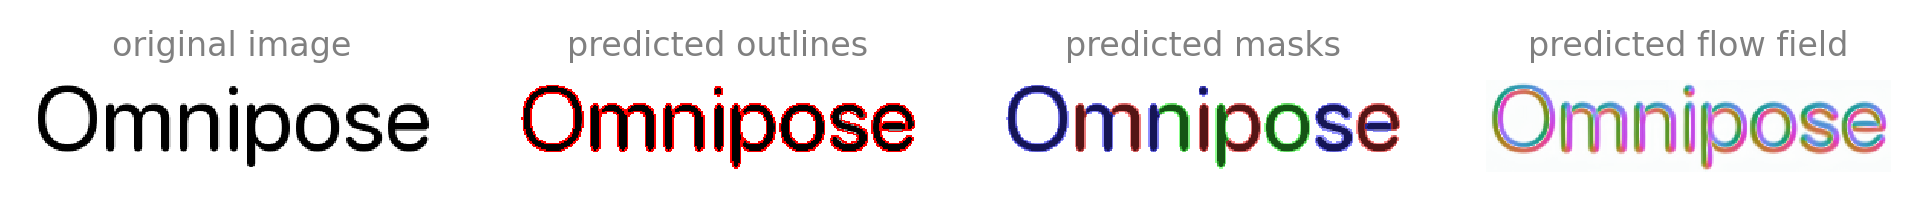

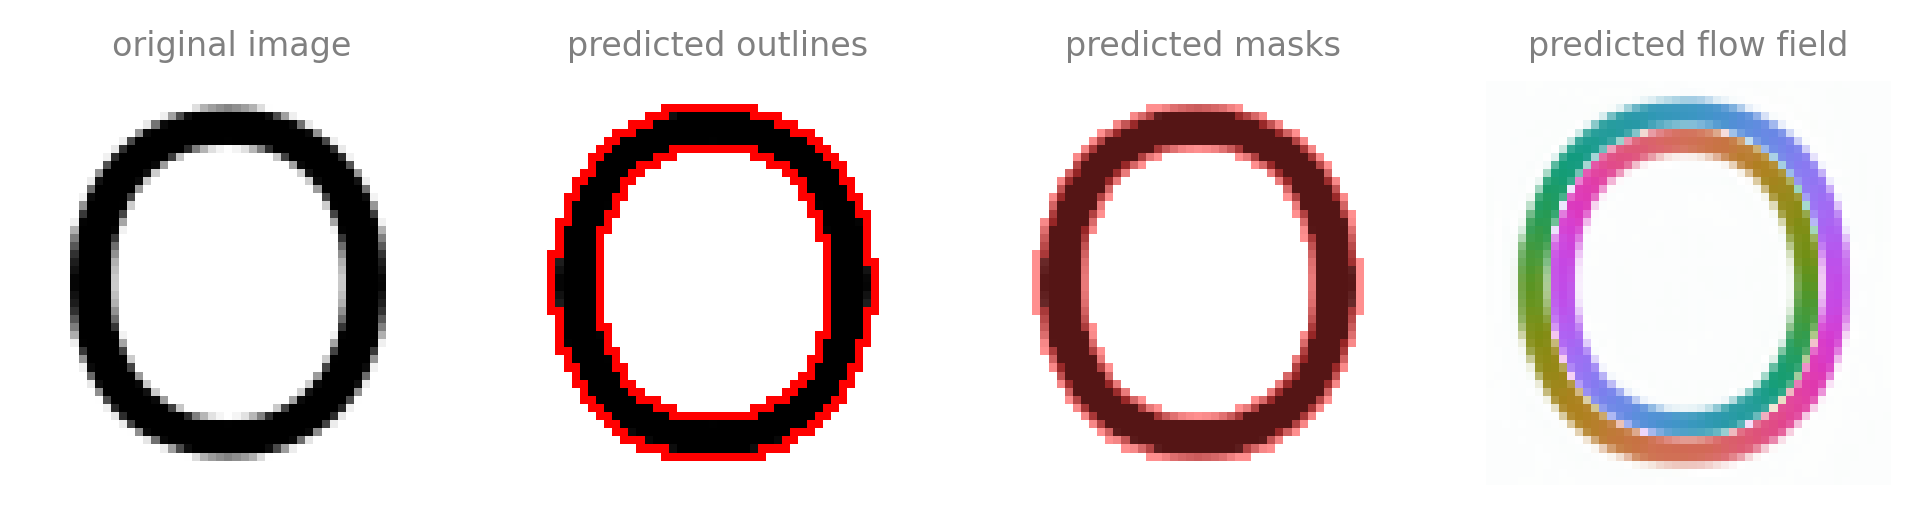

In [ ]:
cmocean:

2025-06-30 03:01:23,317	[INFO]     cellpose_omni/models.py                   	 line 436	>>bact_phase_omni<< model set to be used
2025-06-30 03:01:23,318	[INFO]     cellpose_omni/core.py         assi...evice()	 line  67	Using GPU.
2025-06-30 03:01:23,423	[INFO]                                   __init__....()	 line 173	u-net config: ([2, 32, 64, 128, 256], 4, 2)


  0%|          | 0/2 [00:00<?, ?it/s]

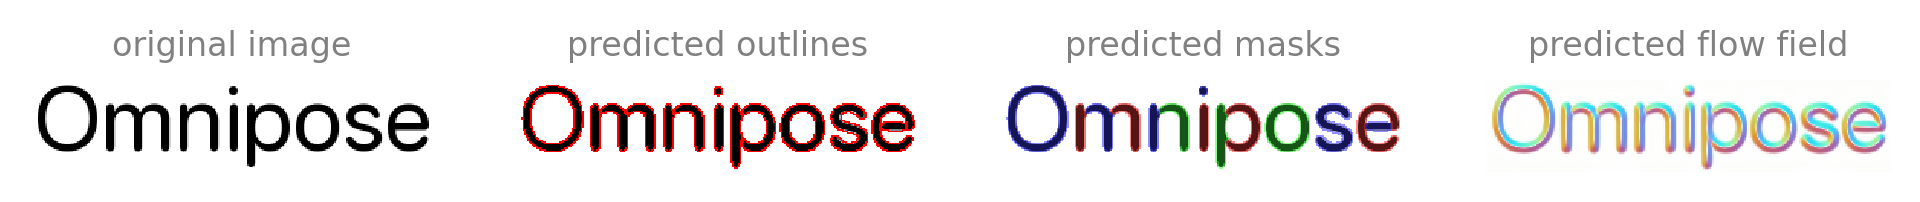

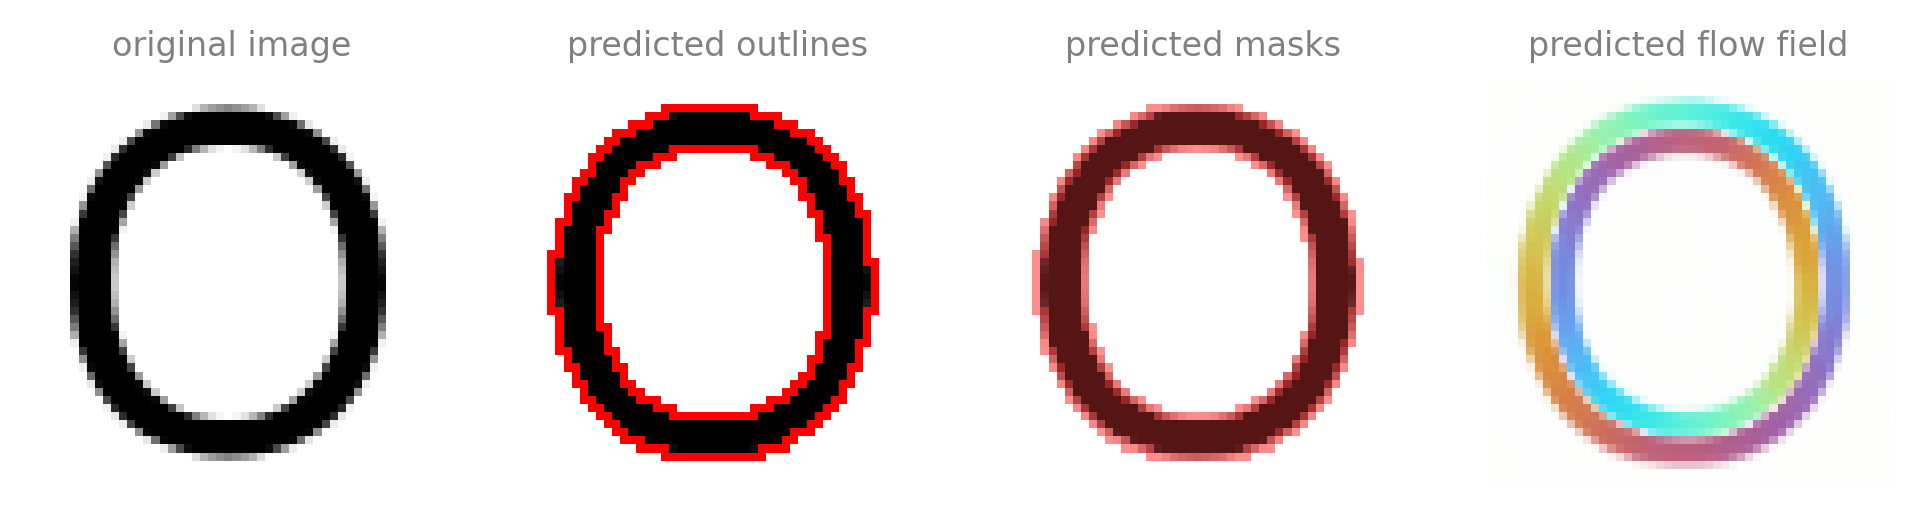

2025-06-29 17:11:11,525	[INFO]     cellpose_omni/models.py                   	 line 436	>>bact_phase_omni<< model set to be used
2025-06-29 17:11:11,526	[INFO]     cellpose_omni/core.py         assi...evice()	 line  67	Using GPU.
2025-06-29 17:11:11,628	[INFO]                                   __init__....()	 line 173	u-net config: ([2, 32, 64, 128, 256], 4, 2)


  0%|          | 0/2 [00:00<?, ?it/s]

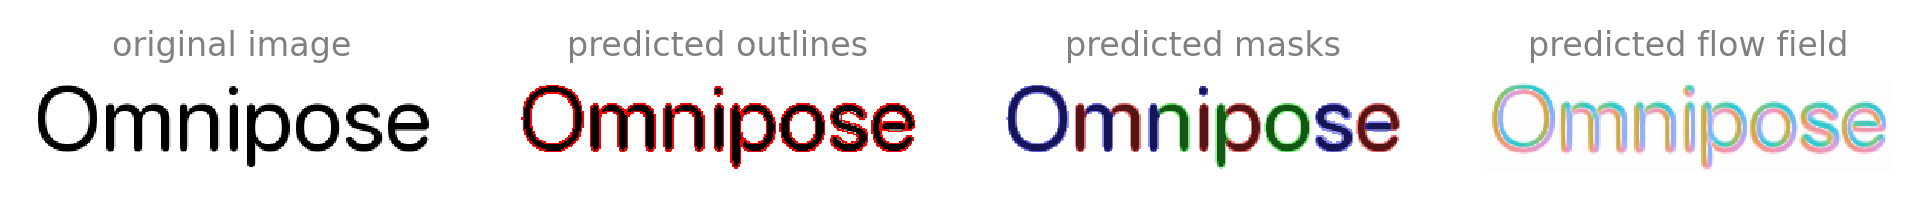

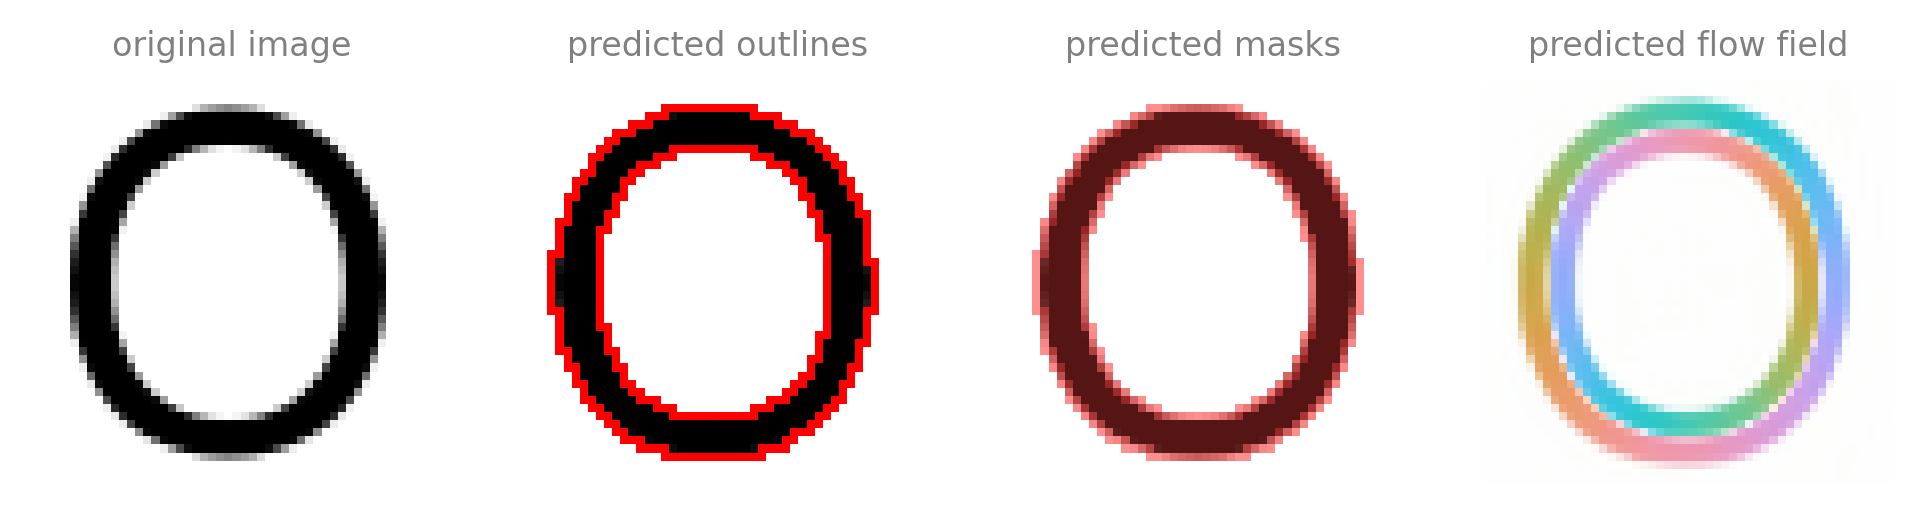

In [ ]:
# make a gif of rotating the hue angle on flow 

In [ ]:
import cellpose_omni
a = 2*np.pi
frames= [cellpose_omni.plot.dx_to_circ(flows[-1][1], offset=o, transparency=1) for o in np.arange(0,a,a/30)]
# imshow(rgbs)
omnipose.misc.export_gif(np.stack(frames,axis=0),'o','/Users/kcutler/Downloads/', scale=10, bounce=0)

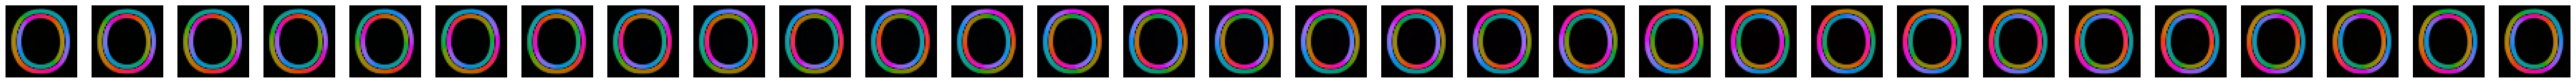

In [ ]:
imshow(frames)

2025-06-29 04:21:04,807	[INFO]     cellpose_omni/models.py                   	 line 436	>>bact_phase_omni<< model set to be used
2025-06-29 04:21:04,808	[INFO]     cellpose_omni/core.py         assi...evice()	 line  67	Using GPU.
2025-06-29 04:21:04,917	[INFO]                                   __init__....()	 line 173	u-net config: ([2, 32, 64, 128, 256], 4, 2)


  0%|          | 0/2 [00:00<?, ?it/s]

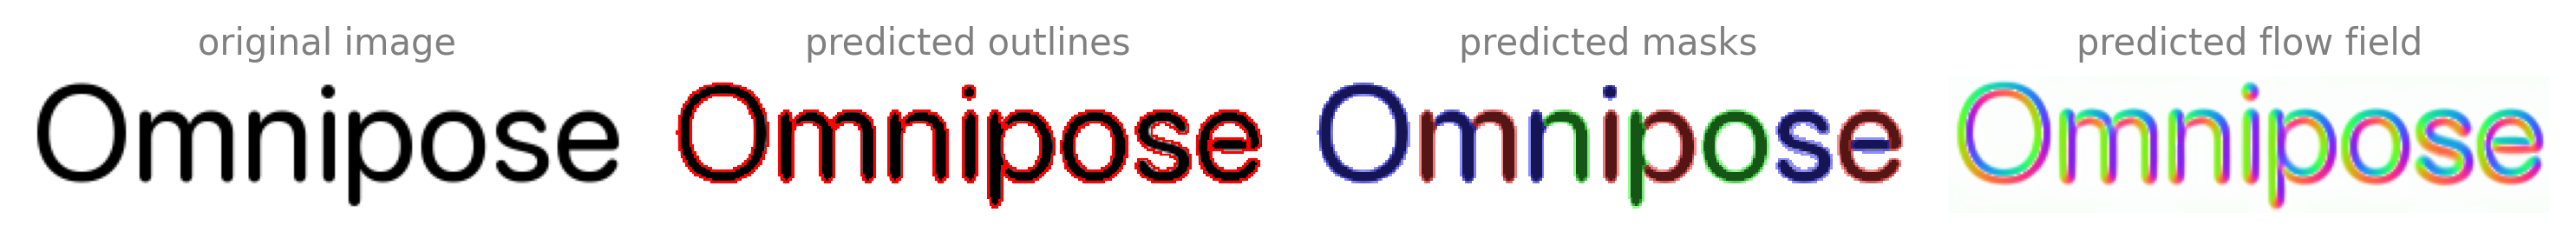

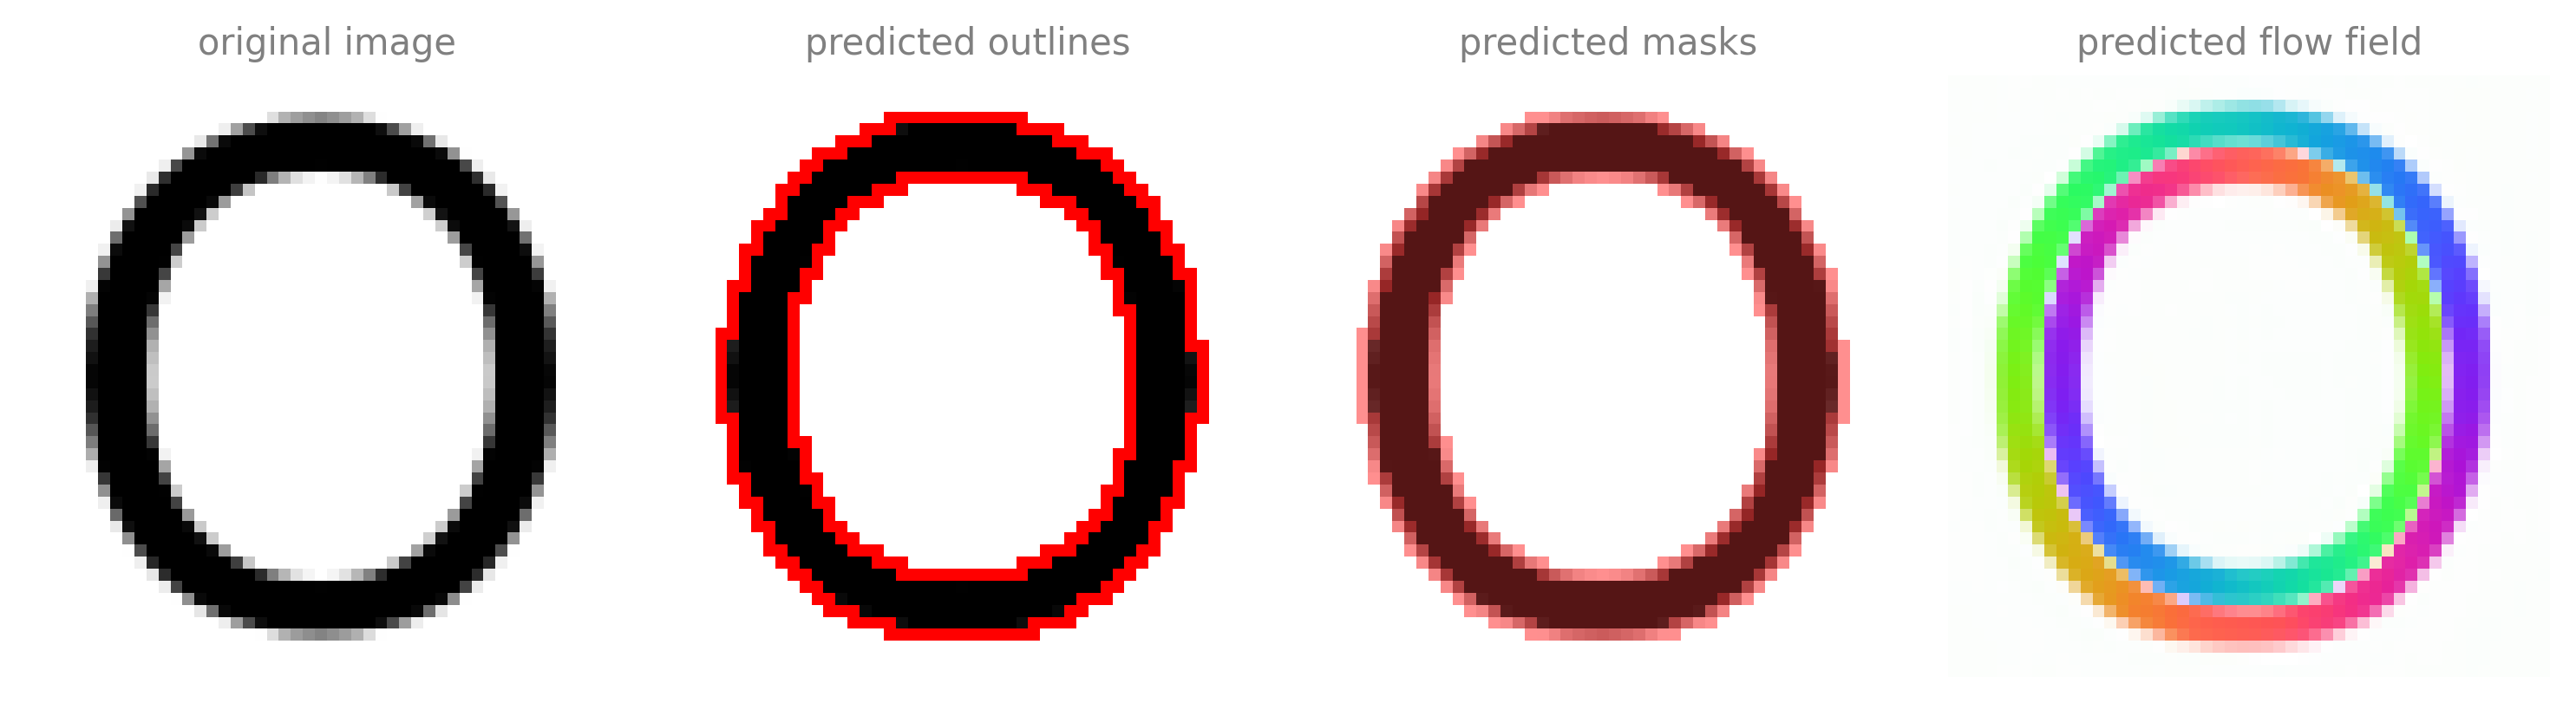

I landed on this font because it is one of Apple's system defaults (and therefore works well with the system fonts used on our website when viewed on Apple devices), and I chose this scale because it is very close to bacteria and showed a good amount of 'segmentation' in the M, N, P, and E from purely local morphology (cusps). This gives reasonable output at higher-resolution text (wider 'cells'), but it starts to hallucinate output between objects if the size gets too large. 


{header-2}`Adjusting transparency`
----------------------------------
The transparency (alpha channel) is set by the flow magnitude, and the color (RGB channels) is set by the flow angle according to a shifted sinebow relation:
```python
angles = np.arctan2(dP[1], dP[0])+np.pi
r = ((np.cos(angles)+1)/2)
g = ((np.cos(angles+2*np.pi/3)+1)/2)
b =((np.cos(angles+4*np.pi/3)+1)/2)
```
(a is just a constant, not alpha). The slight tinge of green comes from the fact that {py}`np.arctan2(0,0)=0` and {py}`((np.cos(0+2*np.pi/3)+1)/2) = 1/4`. I'll try two ways to remove it: 
first by removing any average background bias, second by adjusting the alpha channel so that the background alpha is 0 on average. 

avarage bias is [0.062608756, 0.06555136], average angle is 0.25730722792217886 pi rad.


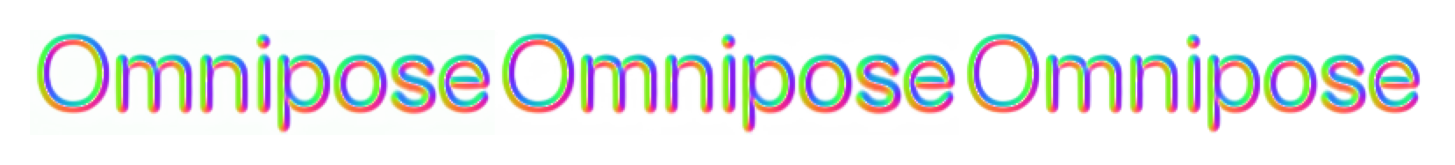

avarage bias is [0.061921515, 0.06161317], average angle is 0.24920548520168206 pi rad.


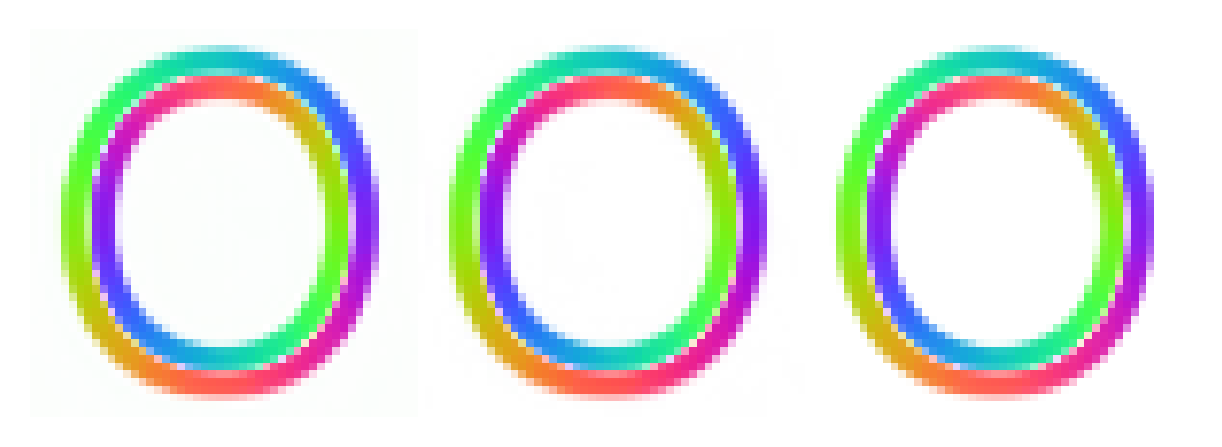

In [ ]:
import skimage.io
import os
from omnipose.utils import normalize99, rescale
from scipy.ndimage import zoom
from pathlib import Path

omnidir = Path(omnipose.__file__).parent.parent.parent
basedir = os.path.join(omnidir,'docs','_static')
names = ['logo.png','icon.ico']
ext = '.png'

for idx,i in enumerate(n):

    maski = masks[idx]
    flowi = flows[idx][0]
    dPi = flows[idx][1]
    bias = [np.mean(d[maski==0]) for d in dPi]
    angle = np.arctan2(bias[1], bias[0]) / np.pi
    print('avarage bias is {}, average angle is {} pi rad.'.format(bias,angle))
    dPi_new = np.stack([np.clip(d - b,-np.inf,np.inf) for d,b in zip(dPi,bias)])
    flowi_new = plot.dx_to_circ(dPi_new,transparency=True)
    
    flowi_3 = flowi.copy()
    alpha = flowi_3[...,-1]
    flowi_3[...,-1] = rescale(np.clip(alpha-np.mean(alpha[maski==0]),0,np.inf))*255
    
    f = 30
    szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
    szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
    fig = plt.figure(figsize=(szY,szX*4))
    fig.patch.set_facecolor([0]*4)
    
    plt.imshow(np.hstack([flowi,flowi_new,flowi_3]))
    plt.axis('off')
    plt.show()
    # aplha channel correction is the winner
    # also rescale the image without interpolation so that, when displayed as favicon etc., it is not as smoothed out - we want to show real output 
    skimage.io.imsave(os.path.join(basedir,names[idx]),zoom(flowi_3,(3,)*(flowi.ndim-1)+(1,),order=0)) 
    

Turns out that subtracting off the flow component bias introduces some over-correction in places, leading to some discoloration. So, alpha adjustment it is. It might be hard for you to see it, but I can. This level of pixel-peeping is how I made my ground-truth data ;-) 

{header-2}`Exporting`
---------------------
Favicons need to be a particular resolution. For now I am making a multi-scale .ico, but that isn't working properly on Safari (too pixelated). Seems like multiple separate PNGs is the way to go moving forward. 

In [ ]:
from PIL import Image
filename = os.path.join(basedir,names[-1])
zimgs = []

for j,sz in enumerate([(32,32), (128,128), (180,180), (192,192)]):
    scale = np.array(sz)/np.array(flowi_3.shape[0:2])
    zimg = zoom(flowi_3,tuple(scale)+(1,),order=(np.max(scale)<1)) 
    zimgs.append(zimg)
    # plt.imshow(zimg)
    # plt.axis('off')
    # plt.show()
    # zimg.shape

icon = Image.fromarray(zimgs[0], 'RGBA')
icon.save(filename,append_images=[Image.fromarray(z, 'RGBA') for z in zimgs[1:]])

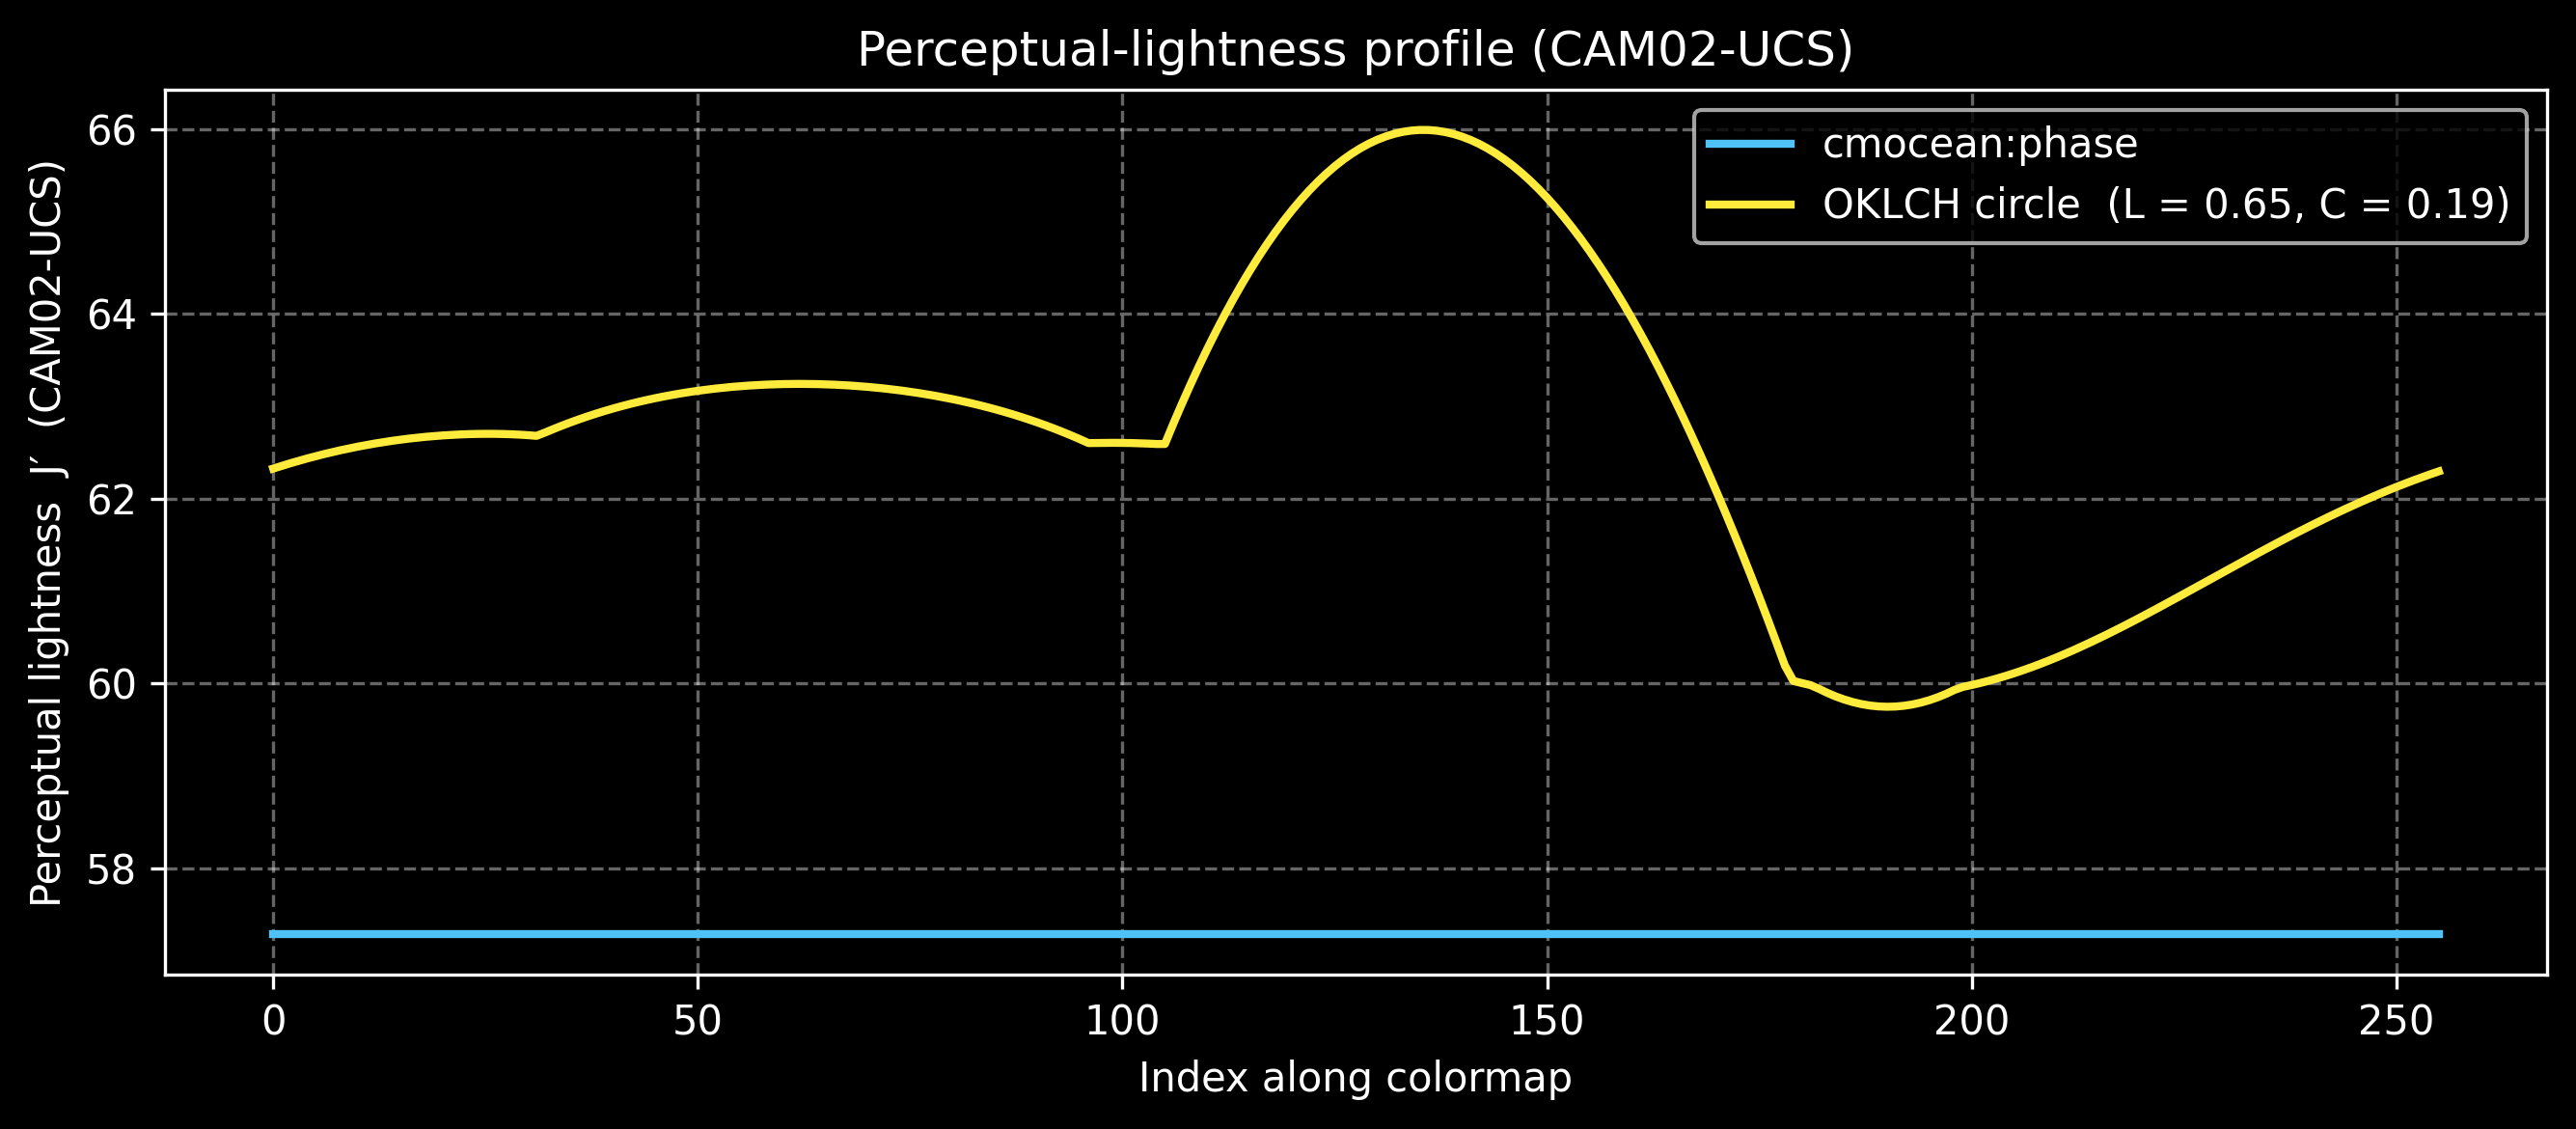

In [ ]:
"""
Perceptual-lightness (CAM02-UCS J′) comparison
• cmocean:phase vs • OKLCH constant-L circle

Run once:
    pip install numpy matplotlib cmap colorspacious
"""

import subprocess, sys, importlib.util
# ---------- ensure colorspacious is present ----------
if importlib.util.find_spec("colorspacious") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "colorspacious"])

import numpy as np
import matplotlib.pyplot as plt
from cmap import Colormap
from colorspacious import cspace_convert

# ────────────────────────── OKLCH constant-L wheel ──────────────────────────
def oklch_circle(n=256, L=0.65, C=0.19, h_offset=0.0):
    """
    Return *n* RGB triples on a constant-L OKLCH circle safe in sRGB.
    """
    t = (np.linspace(0, 1, n, endpoint=False) + h_offset) % 1.0
    h = 2 * np.pi * t
    a = C * np.cos(h)
    b = C * np.sin(h)

    # OKLab → linear RGB  (Ottosson 2020)
    l_ = (L + 0.3963377774 * a + 0.2158037573 * b) ** 3
    m_ = (L - 0.1055613458 * a - 0.0638541728 * b) ** 3
    s_ = (L - 0.0894841775 * a - 1.2914855480 * b) ** 3

    r_lin =  4.0767416621 * l_ - 3.3077115913 * m_ + 0.2309699292 * s_
    g_lin = -1.2684380046 * l_ + 2.6097574011 * m_ - 0.3413193965 * s_
    b_lin = -0.0041960863 * l_ - 0.7034186147 * m_ + 1.7076147010 * s_

    rgb_lin = np.stack([r_lin, g_lin, b_lin], axis=-1)

    # linear-RGB → sRGB
    a_srgb = 0.055
    rgb = np.where(
        rgb_lin <= 0.0031308,
        12.92 * rgb_lin,
        (1 + a_srgb) * np.clip(rgb_lin, 0, 1) ** (1 / 2.4) - a_srgb,
    )
    return np.clip(rgb, 0, 1)

# ────────────────────── sample both colormaps ──────────────────────
N = 256
phase_rgb = np.array(
    [Colormap("cmocean:phase")(float(t)).rgba[:3] for t in np.linspace(0, 1, N, endpoint=False)]
)
oklch_rgb = oklch_circle(N)            # L=0.65, C=0.19

# ─────────────── convert to CAM02-UCS and get J′ ────────────────
phase_Jp = cspace_convert(phase_rgb, "sRGB1", "CAM02-UCS")[:, 0]
oklch_Jp = cspace_convert(oklch_rgb, "sRGB1", "CAM02-UCS")[:, 0]

# ───────────────────────────── plot ──────────────────────────────
plt.figure(figsize=(9, 4))
plt.plot(phase_Jp, label="cmocean:phase", lw=2, color="#4FC3F7")
plt.plot(oklch_Jp, label="OKLCH circle  (L = 0.65, C = 0.19)", lw=2, color="#FFEB3B")
plt.xlabel("Index along colormap")
plt.ylabel("Perceptual lightness  J′  (CAM02-UCS)")
plt.title("Perceptual-lightness profile (CAM02-UCS)")
plt.grid(ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

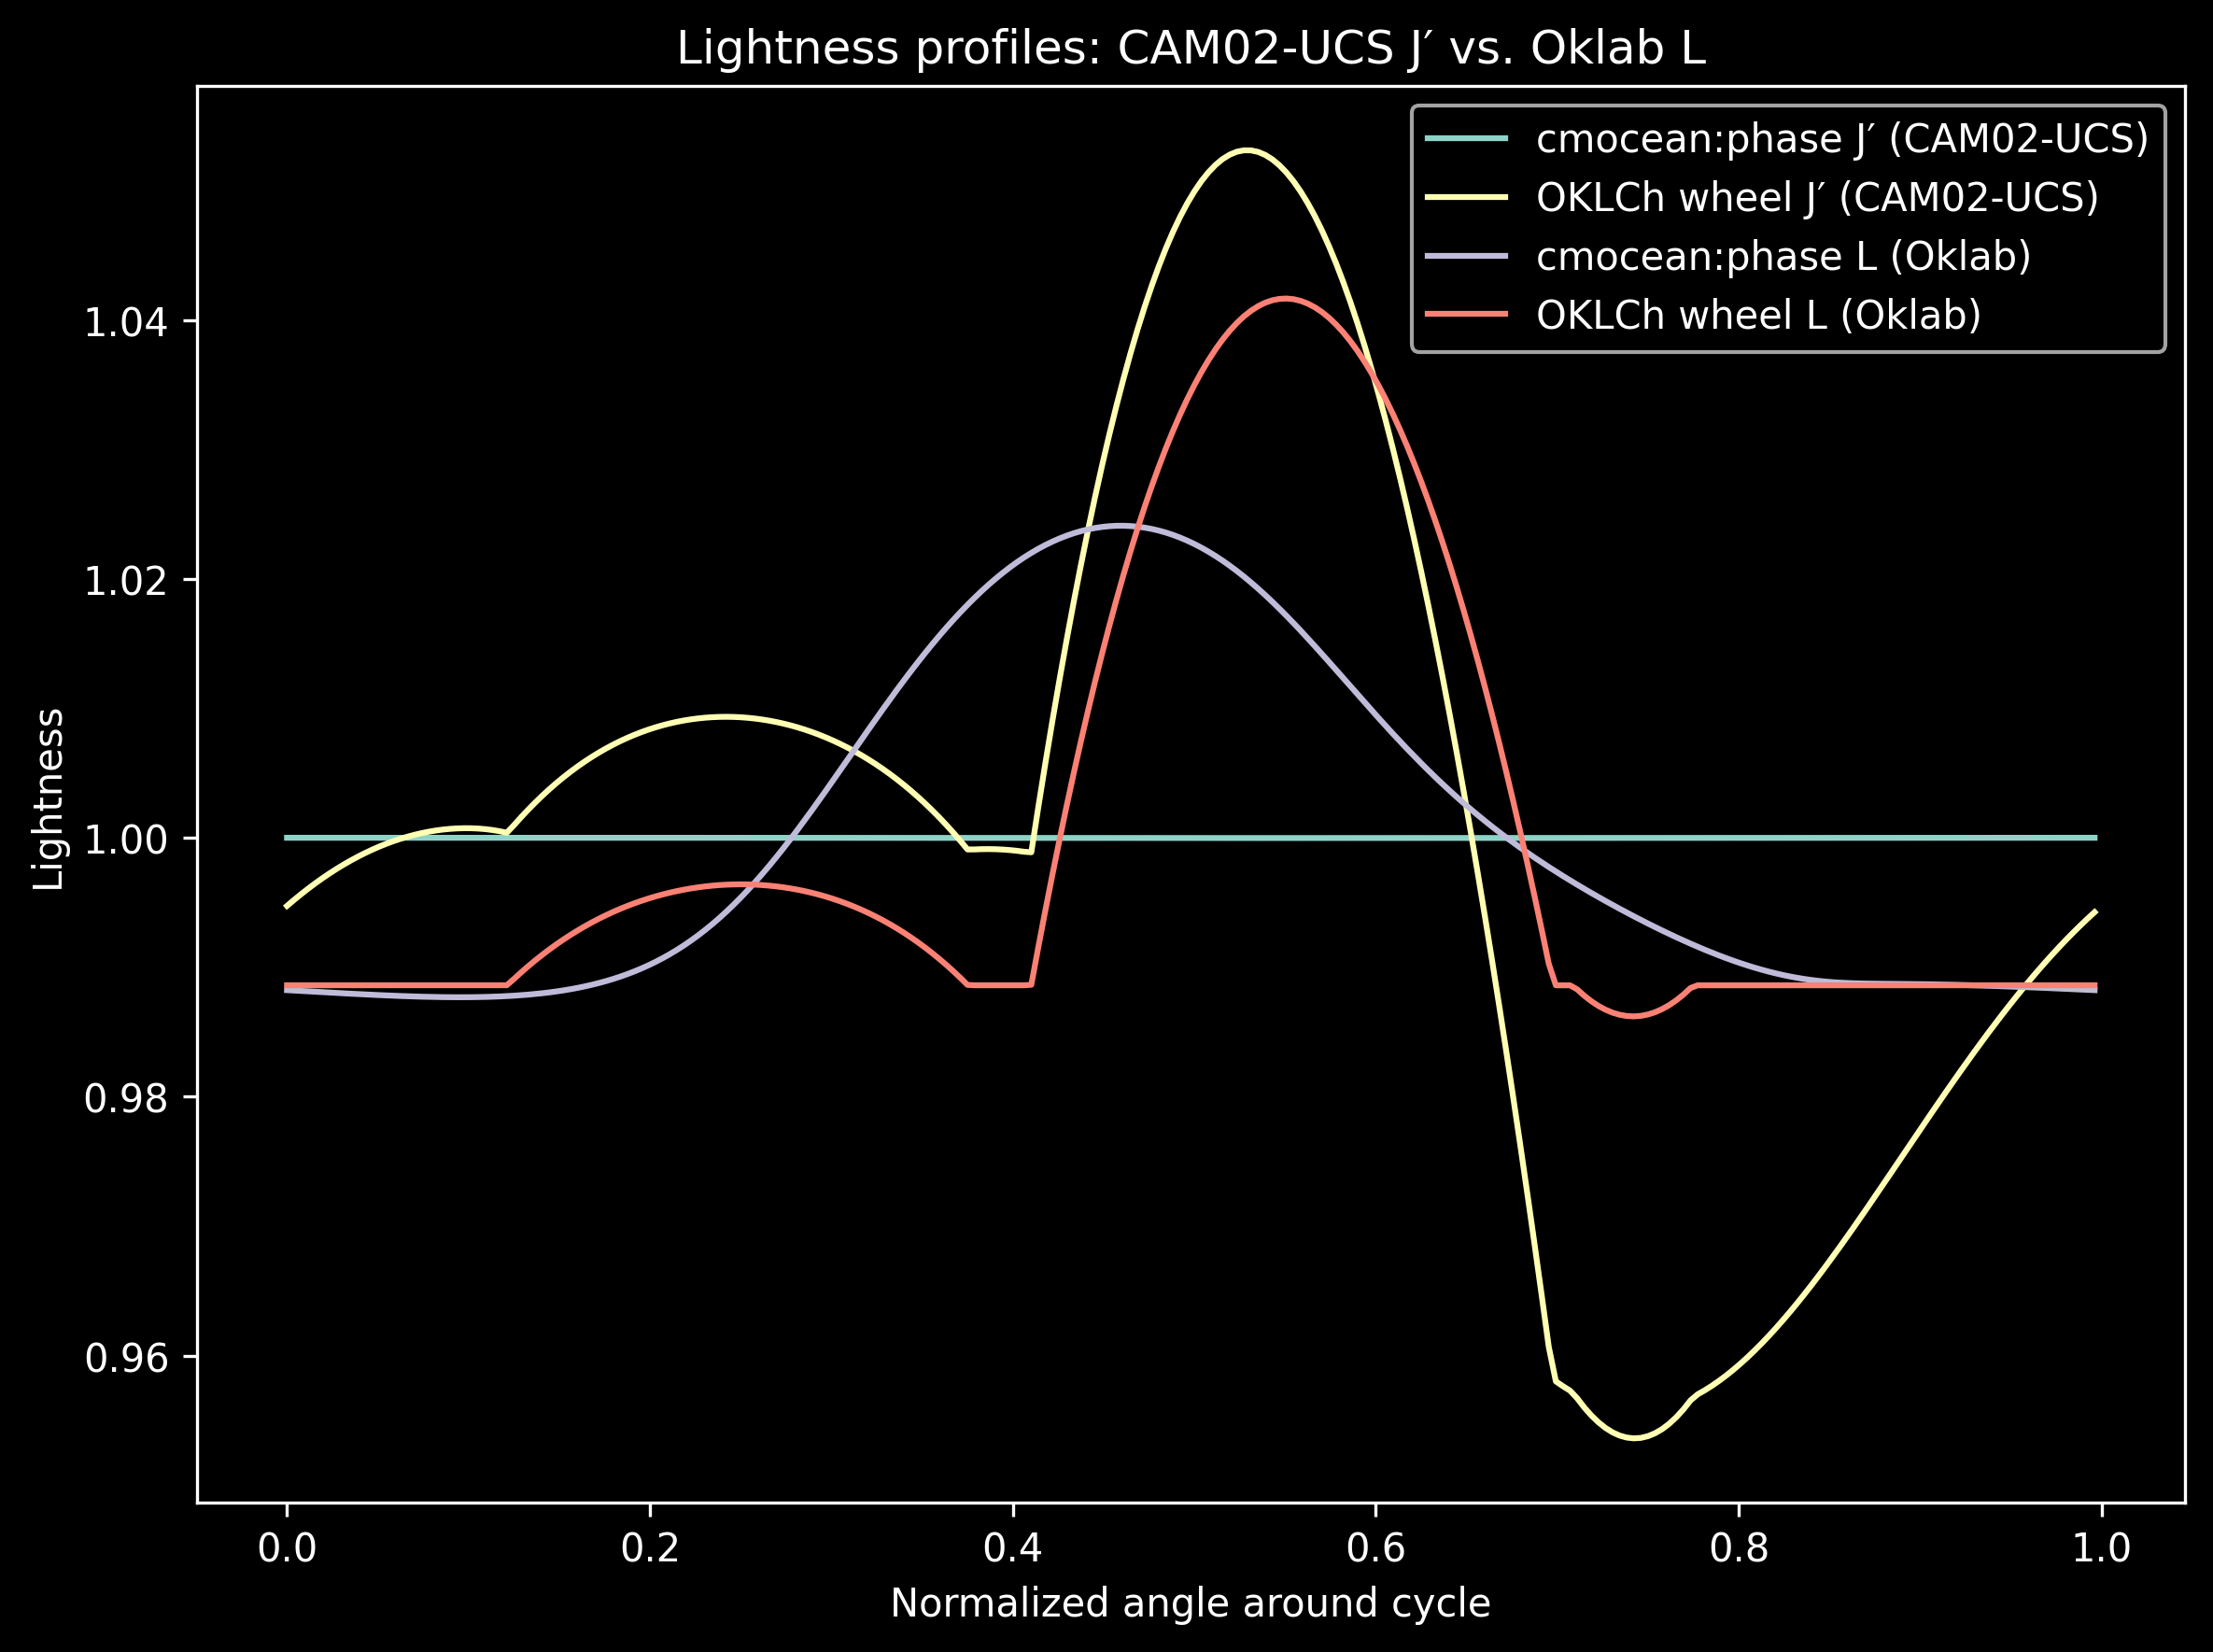

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cmap import Colormap
from colour import (
    sRGB_to_XYZ,          # sRGB → XYZ (D65) 
    XYZ_to_CAM02UCS,      # XYZ → CAM02-UCS J′a′b′  [oai_citation:2‡colour.readthedocs.io](https://colour.readthedocs.io/en/v0.4.4/generated/colour.XYZ_to_CAM02UCS.html?utm_source=chatgpt.com)
    XYZ_to_Oklab,         # XYZ → Oklab L a b  [oai_citation:3‡colour.readthedocs.io](https://colour.readthedocs.io/en/v0.4.6/generated/colour.XYZ_to_Oklab.html?utm_source=chatgpt.com)
    Oklab_to_XYZ,         # Oklab → XYZ  [oai_citation:4‡colour.readthedocs.io](https://colour.readthedocs.io/en/latest/colour.models.html?utm_source=chatgpt.com)
    XYZ_to_sRGB           # XYZ → sRGB  [oai_citation:5‡colour.readthedocs.io](https://colour.readthedocs.io/en/develop/generated/colour.XYZ_to_sRGB.html?utm_source=chatgpt.com)
)

def oklch_cycle(N=256, L=0.65, C=0.19, h_offset=0.0):
    """
    Generate a cyclic, constant-L OKLCh wheel in sRGB space.
    """
    t = np.linspace(0, 1, N, endpoint=False)
    h = 2 * np.pi * (t + h_offset)
    # OKLCh → Oklab
    Lab = np.stack([L * np.ones_like(h),
                    C * np.cos(h),
                    C * np.sin(h)], axis=-1)
    # Convert Oklab → XYZ → sRGB
    XYZ = Oklab_to_XYZ(Lab)
    rgb = XYZ_to_sRGB(XYZ)
    return np.clip(rgb, 0, 1)

# Number of samples around the circle
N = 256
t = np.linspace(0, 1, N, endpoint=False)

# 1) Sample cmocean:phase
phase = Colormap("cmocean:phase")
phase_rgb = np.array([phase(float(v)).rgba[:3] for v in t])

# 2) Sample OKLCh constant-L wheel
oklch_rgb = oklch_cycle(N)

# 3) Convert both → XYZ
phase_XYZ = sRGB_to_XYZ(phase_rgb)
oklch_XYZ = sRGB_to_XYZ(oklch_rgb)

# 4) Compute CAM02-UCS J′
phase_Jpab = XYZ_to_CAM02UCS(phase_XYZ)
oklch_Jpab = XYZ_to_CAM02UCS(oklch_XYZ)
phase_Jp  = phase_Jpab[:, 0]
oklch_Jp  = oklch_Jpab[:, 0]

# 5) Compute Oklab L
phase_Lab = XYZ_to_Oklab(phase_XYZ)
oklch_Lab = XYZ_to_Oklab(oklch_XYZ)
phase_L   = phase_Lab[:, 0]
oklch_L   = oklch_Lab[:, 0]

# 6) Plot
plt.figure(figsize=(8, 6))
plt.plot(t, phase_Jp/phase_Jp.mean(),  label="cmocean:phase J′ (CAM02-UCS)")
plt.plot(t, oklch_Jp/oklch_Jp.mean(),  label="OKLCh wheel J′ (CAM02-UCS)")
plt.plot(t, phase_L/phase_L.mean(),   label="cmocean:phase L (Oklab)")
plt.plot(t, oklch_L/oklch_L.mean(),   label="OKLCh wheel L (Oklab)")
plt.xlabel("Normalized angle around cycle")
plt.ylabel("Lightness")
plt.title("Lightness profiles: CAM02-UCS J′ vs. Oklab L")
plt.legend()
plt.tight_layout()
plt.show()

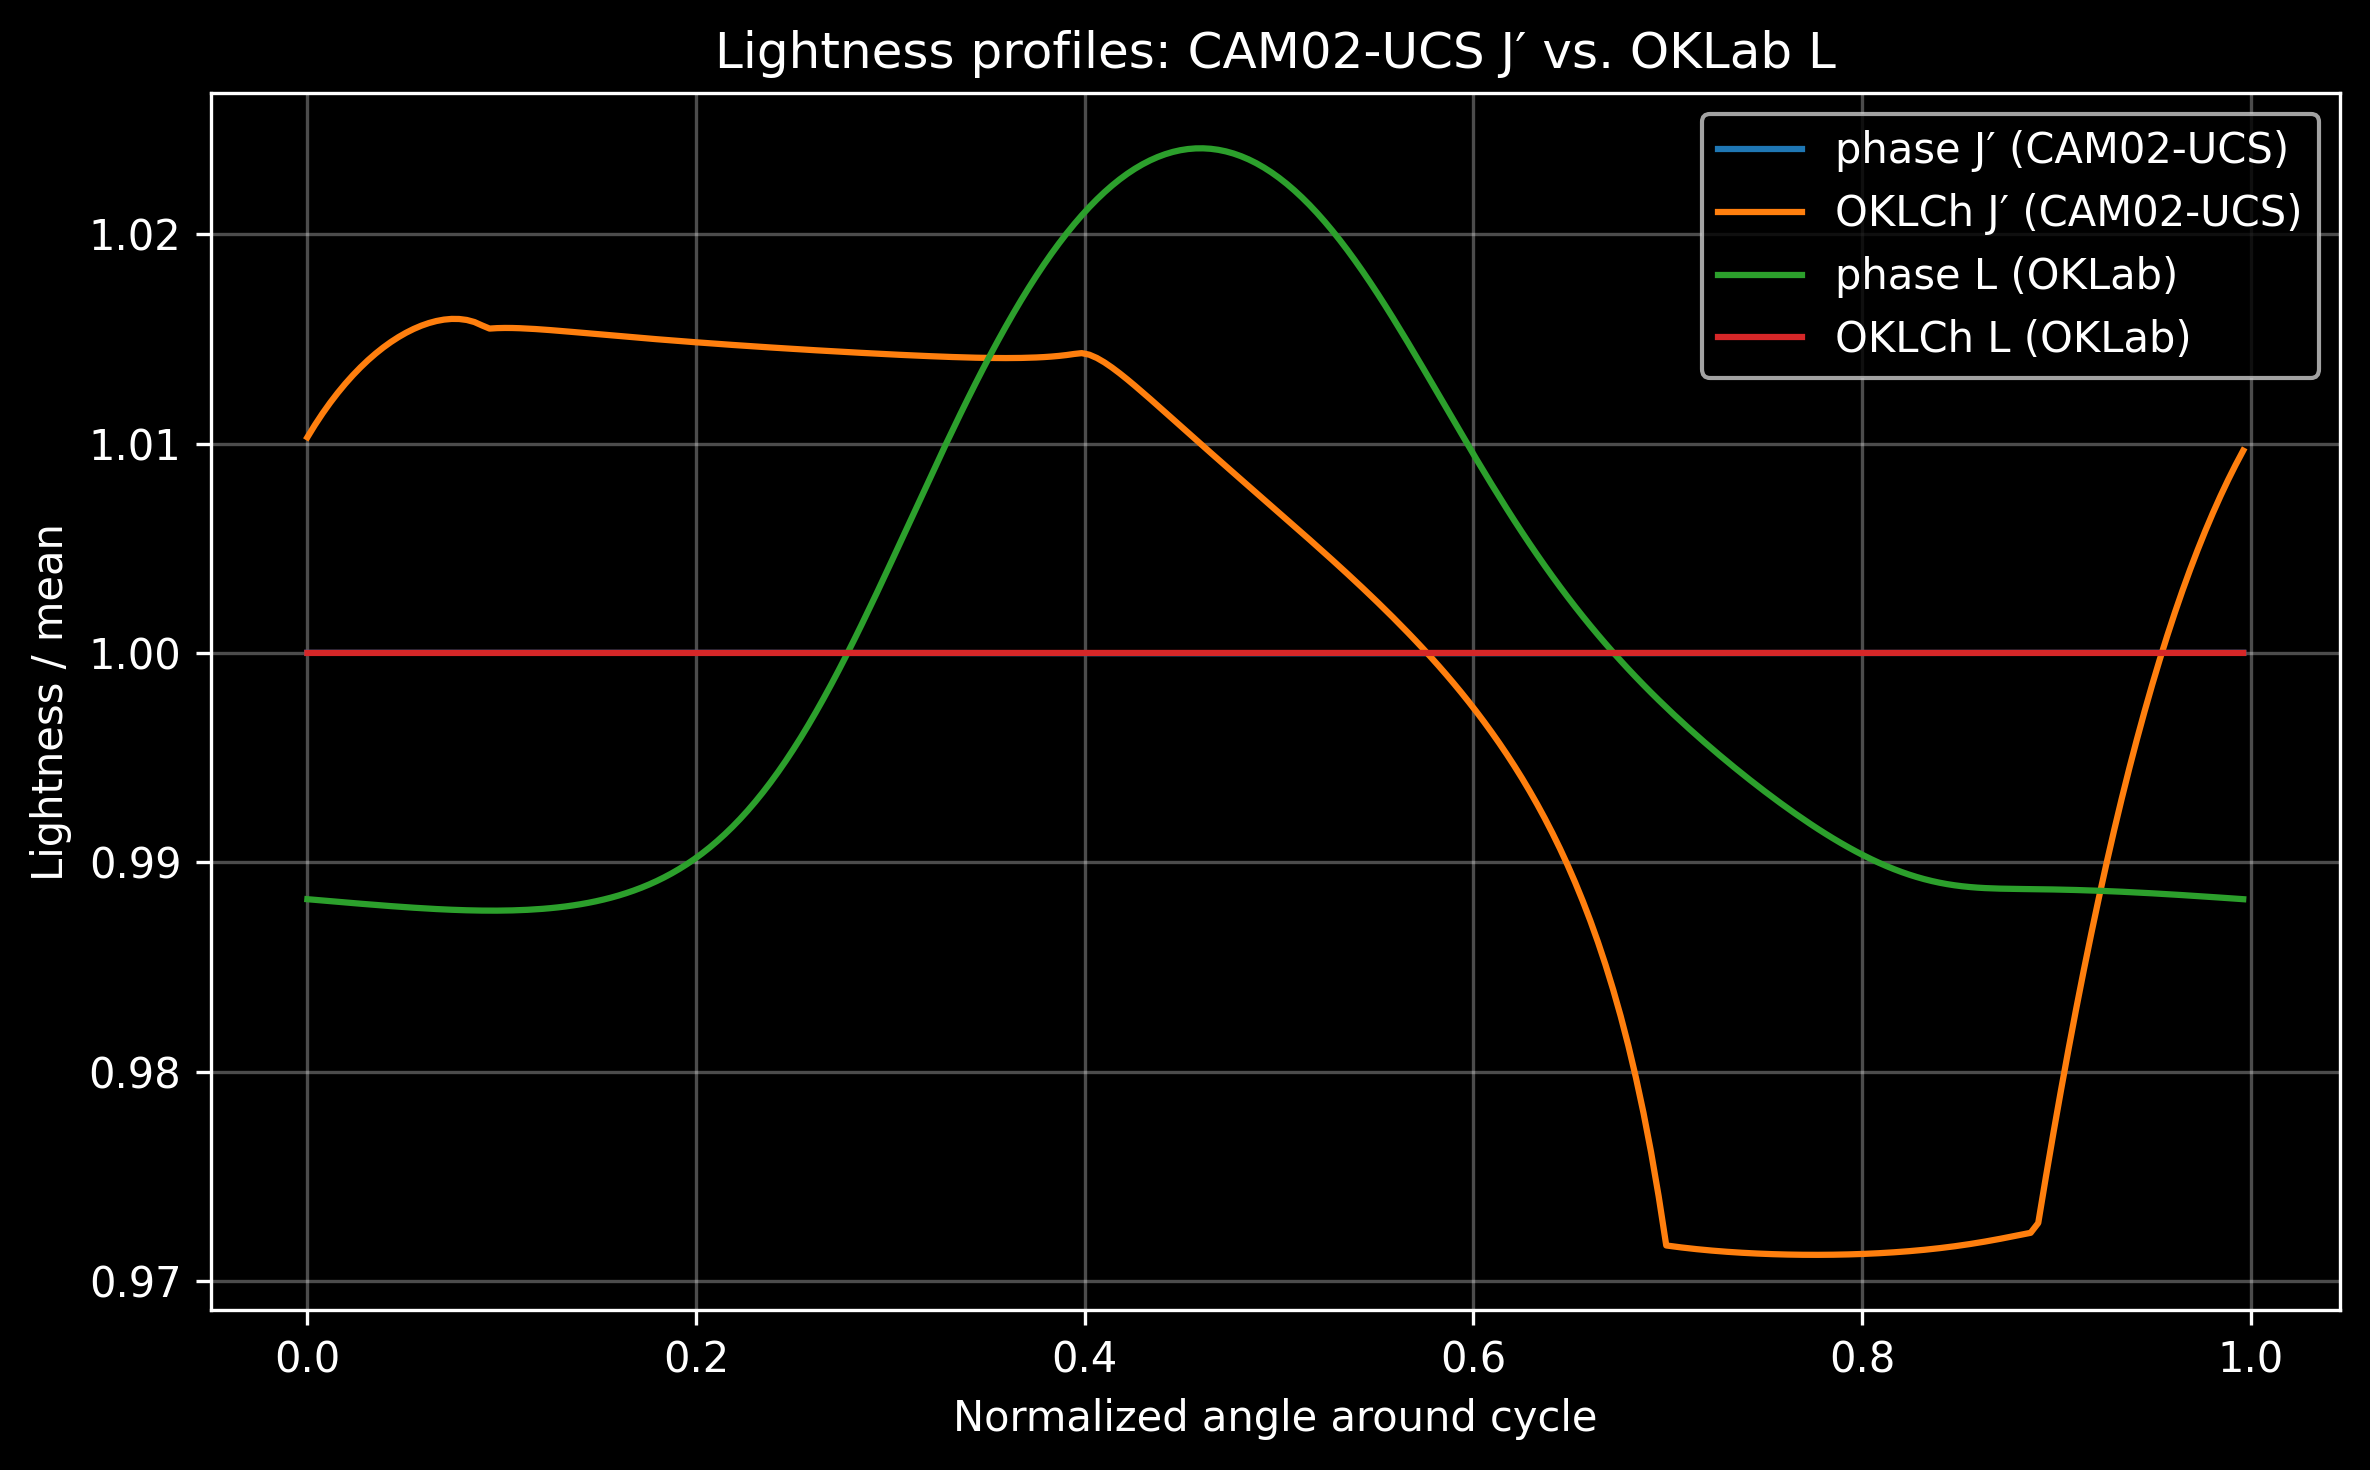

In [ ]:
"""
Compare lightness profiles of cmocean:phase vs. a maximally-saturated OKLCh wheel
with optional mean-normalization.

Dependencies:
    pip install numpy matplotlib cmocean cmap colour-science
"""

import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo                # pip install cmocean
from cmap import Colormap                # pip install cmap
from colour import (
    sRGB_to_XYZ,      # sRGB → XYZ (D65)
    XYZ_to_sRGB,      # XYZ → sRGB
    XYZ_to_CAM02UCS,  # XYZ → CAM02-UCS J′a′b′
    XYZ_to_Oklab,     # XYZ → OKLab L a b
    Oklab_to_XYZ      # OKLab → XYZ
)

def build_max_saturated_wheel(N=256, L0=0.65):
    """
    For each hue, find the max chroma that still fits in sRGB
    at constant lightness L0, then build the OKLCh wheel.
    """
    hues = np.linspace(0, 2*np.pi, N, endpoint=False)
    Cmax = np.zeros(N)
    for i, h in enumerate(hues):
        lo, hi = 0.0, 0.5
        for _ in range(30):
            C = 0.5*(lo+hi)
            Lab = np.array([L0, C*np.cos(h), C*np.sin(h)])
            rgb = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
            if np.all((rgb>=0)&(rgb<=1)):
                lo = C
            else:
                hi = C
        Cmax[i] = lo #* 0.98  # small safety margin

    wheel = np.zeros((N,3))
    for i, h in enumerate(hues):
        Lab = np.array([L0, Cmax[i]*np.cos(h), Cmax[i]*np.sin(h)])
        wheel[i] = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
    return wheel

def compute_profiles(N=256, L0=0.65, divide_by_mean=False):
    t = np.linspace(0, 1, N, endpoint=False)

    # 1) cmocean:phase
    phase_map = Colormap("cmocean:phase")
    phase_rgb = np.array([phase_map(float(v)).rgba[:3] for v in t])

    # 2) OKLCh wheel (max saturated at L0)
    wheel_oklch = build_max_saturated_wheel(N, L0)

    # 3) Convert to XYZ
    xyz_phase  = sRGB_to_XYZ(phase_rgb)
    xyz_oklch  = sRGB_to_XYZ(wheel_oklch)

    # 4) CAM02-UCS J′
    Jp_phase = XYZ_to_CAM02UCS(xyz_phase)[:, 0]
    Jp_oklch = XYZ_to_CAM02UCS(xyz_oklch)[:, 0]

    # 5) OKLab L
    L_phase  = XYZ_to_Oklab(xyz_phase)[:, 0]
    L_oklch  = XYZ_to_Oklab(xyz_oklch)[:, 0]

    if divide_by_mean:
        Jp_phase /= Jp_phase.mean()
        Jp_oklch /= Jp_oklch.mean()
        L_phase  /= L_phase.mean()
        L_oklch  /= L_oklch.mean()

    return t, Jp_phase, Jp_oklch, L_phase, L_oklch

def plot_profiles(divide_by_mean=False):
    t, Jp_ph, Jp_ok, L_ph, L_ok = compute_profiles(divide_by_mean=divide_by_mean)

    plt.figure(figsize=(8, 5))
    plt.plot(t, Jp_ph, label="phase J′ (CAM02-UCS)",   color="#1f77b4")
    plt.plot(t, Jp_ok, label="OKLCh J′ (CAM02-UCS)",    color="#ff7f0e")
    plt.plot(t, L_ph,  label="phase L (OKLab)",        color="#2ca02c")
    plt.plot(t, L_ok,  label="OKLCh L (OKLab)",         color="#d62728")
    plt.xlabel("Normalized angle around cycle")
    ylabel = "Lightness / mean" if divide_by_mean else "Lightness"
    plt.ylabel(ylabel)
    plt.title("Lightness profiles: CAM02-UCS J′ vs. OKLab L")
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# — Plot raw profiles —
# plot_profiles(divide_by_mean=False)

# — Plot mean-normalized profiles —
plot_profiles(divide_by_mean=True)

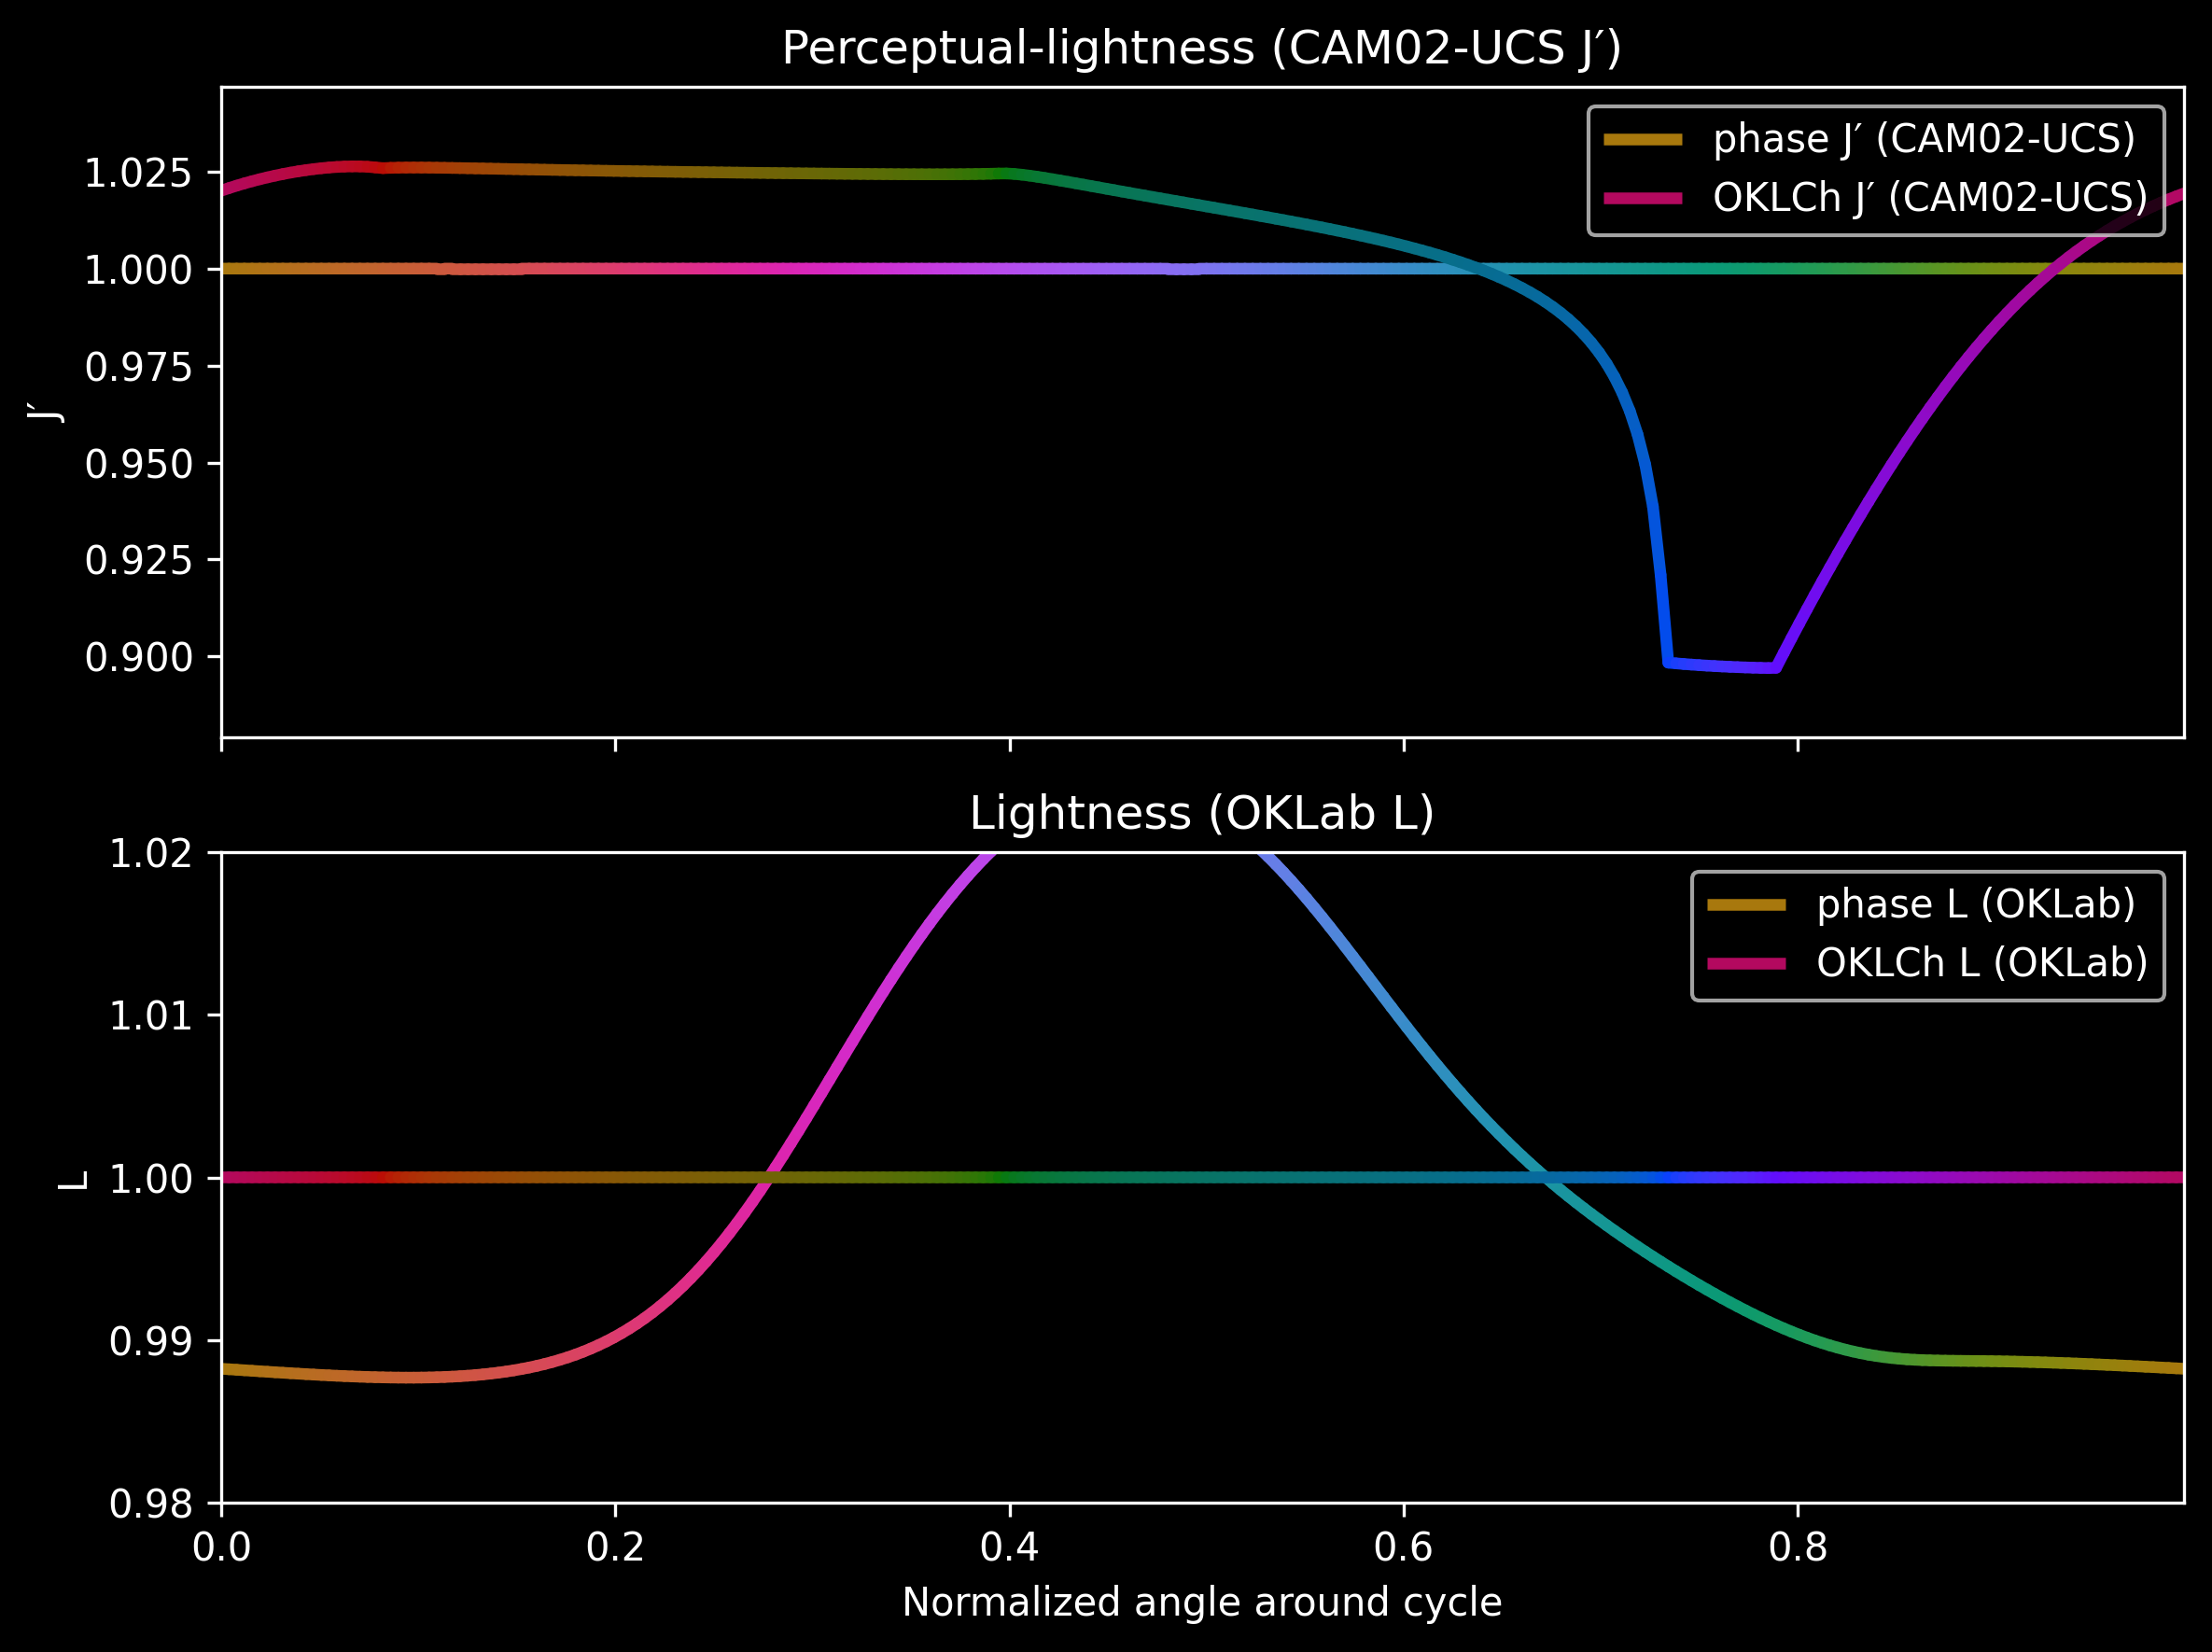

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from cmap import Colormap
from colour import (
    sRGB_to_XYZ,      # sRGB → XYZ
    XYZ_to_CAM02UCS,  # XYZ → CAM02-UCS J′a′b′
    XYZ_to_Oklab,     # XYZ → OKLab L a b
    Oklab_to_XYZ,     # OKLab → XYZ
    XYZ_to_sRGB       # XYZ → sRGB
)

def build_max_saturated_wheel(N=256, L0=0.65):
    hues = np.linspace(0, 2*np.pi, N, endpoint=False)
    Cmax = np.zeros(N)
    for i, h in enumerate(hues):
        lo, hi = 0.0, 0.5
        for _ in range(30):
            C = 0.5*(lo+hi)
            Lab = np.array([L0, C*np.cos(h), C*np.sin(h)])
            rgb = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
            if np.all((rgb>=0)&(rgb<=1)):
                lo = C
            else:
                hi = C
        Cmax[i] = lo * 0.98

    wheel = np.zeros((N,3))
    for i, h in enumerate(hues):
        Lab = np.array([L0, Cmax[i]*np.cos(h), Cmax[i]*np.sin(h)])
        wheel[i] = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
    return wheel

def compute_profiles(N=256, L0=.65, divide_by_mean=False):
    t = np.linspace(0, 1, N, endpoint=False)
    # sample cmocean:phase
    phase_map = Colormap("cmocean:phase")
    phase_rgb = np.array([phase_map(float(v)).rgba[:3] for v in t])
    # sample OKLCh
    oklch_rgb = build_max_saturated_wheel(N, L0)
    # to XYZ
    xyz_phase = sRGB_to_XYZ(phase_rgb)
    xyz_oklch = sRGB_to_XYZ(oklch_rgb)
    # CAM02-UCS J′
    Jp_ph = XYZ_to_CAM02UCS(xyz_phase)[:,0]
    Jp_ok = XYZ_to_CAM02UCS(xyz_oklch)[:,0]
    # OKLab L
    L_ph  = XYZ_to_Oklab(xyz_phase)[:,0]
    L_ok  = XYZ_to_Oklab(xyz_oklch)[:,0]

    if divide_by_mean:
        Jp_ph /= Jp_ph.mean()
        Jp_ok /= Jp_ok.mean()
        L_ph  /= L_ph.mean()
        L_ok  /= L_ok.mean()

    return t, phase_rgb, oklch_rgb, Jp_ph, Jp_ok, L_ph, L_ok

def plot_colored(t, rgb, y, ax, linewidth=3, label=None):
    """
    Plot a line y(t) colored by rgb(t) via LineCollection.
    """
    # Build line segments
    pts = np.column_stack([t, y])
    segs = np.stack([pts[:-1], pts[1:]], axis=1)
    lc = LineCollection(segs, colors=rgb[:-1], linewidth=linewidth, label=label,         capstyle='round',
        joinstyle='round',)
    ax.add_collection(lc)
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(min(y)*0.98, max(y)*1.02)

def plot_profiles(divide_by_mean=False):
    t, phase_rgb, oklch_rgb, Jp_ph, Jp_ok, L_ph, L_ok = compute_profiles(divide_by_mean=divide_by_mean)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # Top: CAM02-UCS J′
    plot_colored(t, phase_rgb, Jp_ph, ax1, label="phase J′ (CAM02-UCS)")
    plot_colored(t, oklch_rgb, Jp_ok, ax1,    label="OKLCh J′ (CAM02-UCS)")
    ax1.set_ylabel("J′")
    ax1.legend(loc="upper right")
    ax1.set_title("Perceptual-lightness (CAM02-UCS J′)")

    # Bottom: OKLab L
    plot_colored(t, phase_rgb, L_ph, ax2, label="phase L (OKLab)")
    plot_colored(t, oklch_rgb, L_ok,  ax2, label="OKLCh L (OKLab)")
    ax2.set_ylabel("L")
    ax2.set_xlabel("Normalized angle around cycle")
    ax2.legend(loc="upper right")
    ax2.set_title("Lightness (OKLab L)")

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_profiles(divide_by_mean=False)   # raw
plot_profiles(divide_by_mean=True)    # mean-normalized

0.13640625


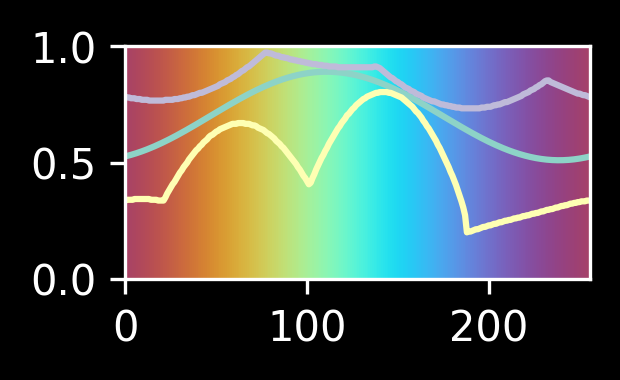

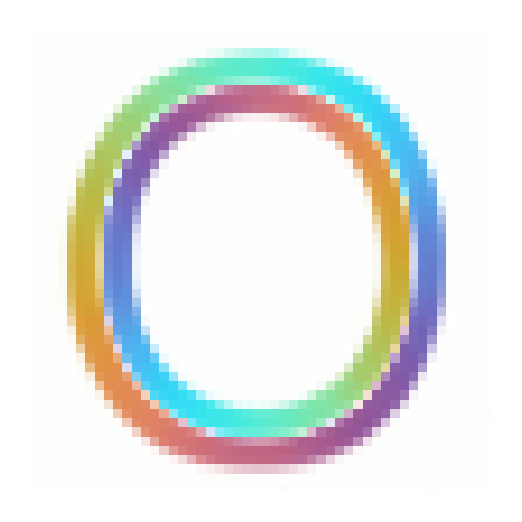

In [ ]:
from cmap import Colormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
from colour import XYZ_to_sRGB, Oklab_to_XYZ                      # already imported above
import numpy as np
from colour import XYZ_to_sRGB, Oklab_to_XYZ

def build_balanced_wheel(N: int = 256,
                         L_samples: int | np.ndarray = 81,
                         margin: float = 0.97,
                         iters: int = 14,
                         guess_range: tuple[float, float] = (0.35, 0.80)):
    """
    OKLCh cyclic palette with uniform chroma at the deepest colour depth
    that all hues can share inside sRGB.

    Returns
    -------
    wheel : (N, 3) ndarray, sRGB on [0, 1]
    L_opt : float — chosen OK Lab lightness
    C_opt : float — chosen common chroma
    """
    # ------------------------------------------------------------------ setup
    if isinstance(L_samples, int):
        L_vals = np.linspace(*guess_range, L_samples, dtype=np.float64)
    else:
        L_vals = np.asarray(L_samples, dtype=np.float64)
    M = L_vals.size

    θ  = np.linspace(0.0, 2.0 * np.pi, N, endpoint=False, dtype=np.float64)
    cθ, sθ = np.cos(θ), np.sin(θ)

    # lower/upper bounds for chroma per (L, hue) pair
    lo = np.zeros((M, N), dtype=np.float64)
    hi = np.full((M, N), 0.5, dtype=np.float64)

    # ---------------------------------------------------------------- search
    for _ in range(iters):
        C   = 0.5 * (lo + hi)                               # midpoint
        # broadcast L to (M, N) so shapes match
        L_arr = L_vals[:, None].repeat(N, axis=1)
        Lab   = np.stack((L_arr, C * cθ, C * sθ), axis=-1)  # (M, N, 3)
        rgb   = XYZ_to_sRGB(Oklab_to_XYZ(Lab))              # broadcasts fine
        ok    = np.all((rgb >= 0.0) & (rgb <= 1.0), axis=-1)
        lo[ok], hi[~ok] = C[ok], C[~ok]                     # binary-search step

    C_max = lo * margin                      # safety margin from gamut edge
    C_min = C_max.min(axis=1)                # uniform chroma per lightness
    idx   = np.argmax(C_min)                 # best lightness index
    L_opt, C_opt = L_vals[idx], C_min[idx]

    # ---------------------------------------------------------------- wheel
    Lab   = np.stack((np.full(N, L_opt), C_opt * cθ, C_opt * sθ), axis=-1)
    wheel = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
    return wheel, float(L_opt), float(C_opt)

import numpy as np
from colour import XYZ_to_sRGB, Oklab_to_XYZ

# ----------------------------------------------------------------------
def _uniform_chroma_at_L(L_vals, cθ, sθ, iters=10, margin=0.97):
    """
    Return, for each lightness in `L_vals`, the largest *uniform* chroma
    every hue can sustain inside sRGB.

    L_vals : (M,) array-like   – candidate OK-Lab lightness values
    cθ,sθ   : (N,)             – cos/sin lookup tables for the hues
    """
    L_vals = np.asarray(L_vals, np.float32)
    M, N   = L_vals.size, cθ.size

    # track chroma bounds **per hue**  → shape (M,N)
    lo = np.zeros((M, N), np.float32)
    hi = np.full((M, N), 0.5, np.float32)

    # repeat L-column N times once; avoids repeat/broadcast in loop
    Lmat = np.repeat(L_vals[:, None], N, axis=1)             # (M,N)

    for _ in range(iters):
        C   = 0.5 * (lo + hi)                                # (M,N)
        Lab = np.stack((Lmat, C * cθ, C * sθ), axis=-1)      # (M,N,3)
        rgb = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
        ok  = np.all((rgb >= 0) & (rgb <= 1), axis=-1)       # (M,N) mask

        lo  = np.where(ok, C, lo)                            # binary search
        hi  = np.where(ok, hi, C)

    return lo.min(axis=1) * margin                           # (M,)

# ----------------------------------------------------------------------
def build_balanced_wheel(N=256, L_range=(0.35, 0.80),
                              coarse=21, fine_step=0.002,
                              margin=0.97, iters=10):
    """
    Band-free OKLCh wheel with deepest common chroma, found by a
    hierarchical (coarse→fine) lightness search.

    Returns
    -------
    wheel : (N,3) ndarray of sRGB in [0,1]
    L_opt : float   chosen OK-Lab lightness
    C_opt : float   chosen uniform chroma
    """
    θ       = np.linspace(0, 2*np.pi, N, endpoint=False, dtype=np.float32)
    cθ, sθ  = np.cos(θ), np.sin(θ)

    # --- coarse sweep ------------------------------------------------------
    L_coarse = np.linspace(*L_range, coarse, dtype=np.float32)
    C_coarse = _uniform_chroma_at_L(L_coarse, cθ, sθ, iters, margin)
    L_best   = float(L_coarse[np.argmax(C_coarse)])

    # --- fine sweep around the best coarse cell ---------------------------
    half = 5 * fine_step                          # ± five steps window
    L_fine = np.arange(L_best - half, L_best + half + fine_step,
                       fine_step, dtype=np.float32)
    C_fine = _uniform_chroma_at_L(L_fine, cθ, sθ, iters, margin)
    j      = int(np.argmax(C_fine))
    L_opt, C_opt = float(L_fine[j]), float(C_fine[j])

    # --- final wheel -------------------------------------------------------
    Lab   = np.stack((np.full(N, L_opt, np.float32),
                      C_opt * cθ, C_opt * sθ), axis=-1)
    wheel = XYZ_to_sRGB(Oklab_to_XYZ(Lab)).astype(np.float32)
    return wheel, L_opt, C_opt

import numpy as np
from colour import XYZ_to_sRGB, Oklab_to_XYZ

# ─────────────────────────────────────────────────────────────────────────────
def build_boundary_wheel(N: int = 256, L0: float = 0.65,
                         margin: float = 0.97, iters: int = 10):
    """
    Constant-L wheel with *per-hue* maximum chroma (no uniform-chroma clamp).

    Parameters
    ----------
    N       – number of discrete hues (samples around the circle)
    L0      – fixed OK-Lab lightness to keep for every colour
    margin  – safety factor (< 1) applied to each hue’s Cₘₐₓ(h)
    iters   – bisection iterations; 10 → ~1 × 10⁻³ precision

    Returns
    -------
    wheel   – (N, 3) ndarray, sRGB in [0, 1]
    C_max   – (N,) ndarray, chroma actually used for every hue
    """
    θ      = np.linspace(0.0, 2.0*np.pi, N, endpoint=False, dtype=np.float32)
    cθ, sθ = np.cos(θ), np.sin(θ)

    # Binary-search bounds for chroma, one scalar per hue
    lo = np.zeros(N, np.float32)
    hi = np.full(N, 0.5, np.float32)
    L  = np.full(N, L0, np.float32)

    for _ in range(iters):
        C   = 0.5 * (lo + hi)                          # midpoint
        Lab = np.stack((L, C*cθ, C*sθ), axis=-1)       # (N,3)
        rgb = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
        ok  = np.all((rgb >= 0) & (rgb <= 1), axis=-1) # inside gamut?

        lo  = np.where(ok, C, lo)                      # raise lower bound
        hi  = np.where(ok, hi, C)                      # lower upper bound

    C_max = lo * margin                                # small safety margin
    Lab   = np.stack((L, C_max*cθ, C_max*sθ), axis=-1)
    wheel = XYZ_to_sRGB(Oklab_to_XYZ(Lab)).astype(np.float32)
    return wheel, C_max


# ----------------------------------------------------------------------
def _cmax_per_hue(L0, cθ, sθ, iters=10):
    """
    Per-hue maximum chroma at fixed OK-Lab lightness L0 (no safety margin).

    Returns
    -------
    C_max : (N,) ndarray
    """
    N  = cθ.size
    lo = np.zeros(N, np.float32)
    hi = np.full(N, 0.5, np.float32)
    L  = np.full(N, L0,   np.float32)

    for _ in range(iters):
        C   = 0.5 * (lo + hi)
        Lab = np.stack((L, C * cθ, C * sθ), axis=-1)
        rgb = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
        ok  = np.all((rgb >= 0) & (rgb <= 1), axis=-1)
        lo  = np.where(ok, C, lo)   # inside → raise lower bound
        hi  = np.where(ok, hi, C)   # outside → lower upper bound
    return lo                       # tight lower bound ≈ C_max

# ----------------------------------------------------------------------
def build_balanced_boundary_wheel(N: int = 256,
                                  L_range=(0.35, 0.80),
                                  coarse: int = 41,
                                  margin: float = 0.97,
                                  iters: int = 10):
    """
    Find the lightness L whose *boundary* chroma curve C_max(h;L) is
    **flattest** (minimum variance), then build the wheel that hugs the
    gamut edge at that L.

    Returns
    -------
    wheel  – (N,3) ndarray, sRGB in [0,1]
    L_opt  – chosen lightness
    C_opt  – (N,) per-hue chroma actually used (after margin)
    """
    θ      = np.linspace(0.0, 2.0*np.pi, N, endpoint=False, dtype=np.float32)
    cθ, sθ = np.cos(θ), np.sin(θ)

    best_var = np.inf
    best_L   = None
    best_C   = None

    for L0 in np.linspace(*L_range, coarse, dtype=np.float32):
        C_raw = _cmax_per_hue(L0, cθ, sθ, iters=iters) * margin
        # coefficient of variation² gives scale-free flatness metric
        var   = np.var(C_raw / C_raw.mean())
        if var < best_var:
            best_var = var
            best_L   = float(L0)
            best_C   = C_raw

    # build wheel at the selected lightness
    Lab   = np.stack((np.full(N, best_L, np.float32),
                      best_C * cθ, best_C * sθ), axis=-1)
    wheel = XYZ_to_sRGB(Oklab_to_XYZ(Lab)).astype(np.float32)
    return wheel, best_L, best_C

# ----------------------------------------------------------------------
def build_balanced_boundary_wheel(

        N: int = 256,
        L_range=(0.35, 0.80),
        coarse: int = 41,
        margin: float = 0.97,
        beta: float  = .5,     # retreat strength (0→raw boundary, 1→balanced)
        gamma: float = 2.0,     # non‑linear exponent for spike suppression
        blur: int    = 0,       # optional circular box‑blur radius (≥0)
        iters: int   = 10,
):
    """
    1. Choose the lightness L whose raw boundary chroma C_max(h;L) has
       the lowest coefficient‑of‑variation (flattest overall).
    2. Pull *spiky* hues inward by an amount that grows **non‑linearly**
       with their excess chroma:

           ΔC   = C_max - C_min
           α(h) = (ΔC / ΔC.max) ** gamma        # emphasis on largest spikes
           C(h) = C_max - beta * α(h) * ΔC

       beta∈[0,1] controls overall retreat strength;
       gamma>1 sharpens the focus on the biggest cusps.
    3. (optional) circular box‑blur the chroma curve (radius = `blur`)
       to remove any residual high‑frequency ripples.
    """
    θ      = np.linspace(0, 2*np.pi, N, endpoint=False, dtype=np.float32)
    cθ, sθ = np.cos(θ), np.sin(θ)

    # helper: per‑hue C_max at fixed lightness
    def _cmax(L0):
        lo = np.zeros(N, np.float32); hi = np.full(N, 0.5, np.float32)
        L  = np.full(N, L0, np.float32)
        for _ in range(iters):
            C   = 0.5*(lo + hi)
            rgb = XYZ_to_sRGB(Oklab_to_XYZ(np.stack((L, C*cθ, C*sθ), axis=-1)))
            ok  = np.all((rgb >= 0) & (rgb <= 1), axis=-1)
            lo, hi = np.where(ok, C, lo), np.where(ok, hi, C)
        return lo                                    # raw C_max

    # ── find flattest boundary lightness ─────────────────────────────────
    best_L, best_C, best_var = None, None, np.inf
    for L0 in np.linspace(*L_range, coarse, dtype=np.float32):
        C_raw = _cmax(L0) * margin
        var   = np.var(C_raw / C_raw.mean())
        if var < best_var:
            best_L, best_C, best_var = float(L0), C_raw, var

    # ── non‑linear retreat from cusps  ───────────────────────────────────
    C_min = best_C.min()
    ΔC    = best_C - C_min
    if ΔC.max() > 0:
        α = (ΔC / ΔC.max()) ** gamma
        C_smooth = best_C - beta * α * ΔC
    else:
        C_smooth = best_C.copy()

    # ── optional circular blur along hue to further mellow artefacts ────
    if blur > 0:
        k  = np.ones(2*blur + 1, np.float32) / (2*blur + 1)
        C_pad = np.pad(C_smooth, (blur, blur), mode='wrap')
        C_smooth = np.convolve(C_pad, k, mode='valid')

    # build wheel
    Lab   = np.stack((np.full(N, best_L, np.float32),
                      C_smooth * cθ, C_smooth * sθ), axis=-1)
    wheel = XYZ_to_sRGB(Oklab_to_XYZ(Lab)).astype(np.float32)
    return wheel, best_L, C_smooth

# ----------------------------------------------------------------------
def build_slice_interpolated_wheel(
        N: int   = 256,
        weight: float = 0,     # 0 → lower boundary, 0.5 → mid-band, 1 → upper
        margin: float = 0.97,
        L_samples: int = 33,     # coarse lightness sweep to bracket Cₘₐₓ(h)
        L_fine: int    = 301,    # fine lightness grid for slice boundaries
        iters: int     = 10,
):
    """
    Uniform-chroma wheel with *varying* lightness:

        1. C₀  = margin · minₕ max_L C_max(h, L)
        2. For each hue, find lowest & highest L where (L, C₀, h) is in-gamut.
        3. Blend those boundaries with `weight`.

    Returns
    -------
    wheel  – (N,3) sRGB colours
    C0     – chosen uniform chroma
    L(h)   – per-hue lightness path actually used
    """
    θ      = np.linspace(0, 2*np.pi, N, endpoint=False, dtype=np.float32)
    cθ, sθ = np.cos(θ), np.sin(θ)

    # -- helper: per-hue C_max at fixed lightness ----------------------------
    def _cmax_per_hue(L0):
        lo = np.zeros(N, np.float32); hi = np.full(N, 0.5, np.float32)
        L  = np.full(N, L0, np.float32)
        for _ in range(iters):
            C   = 0.5*(lo + hi)
            rgb = XYZ_to_sRGB(Oklab_to_XYZ(np.stack((L, C*cθ, C*sθ), -1)))
            ok  = np.all((rgb >= 0) & (rgb <= 1), -1)
            lo, hi = np.where(ok, C, lo), np.where(ok, hi, C)
        return lo                                                       # C_max(h)

    # -- 1. global uniform chroma C₀ ----------------------------------------
    C_max_h = np.zeros(N, np.float32)
    for L0 in np.linspace(0, 1, L_samples, dtype=np.float32):
        C_max_h = np.maximum(C_max_h, _cmax_per_hue(L0))
    C0 = C_max_h.min() * margin

    # -- 2. hue-wise slice boundaries at that C₀ ----------------------------
    L_f = np.linspace(0, 1, L_fine, dtype=np.float32)[:, None]          # (L,1)
    # --- replaces the old Lab = np.stack(...) line ------------------------
    L_mat = np.repeat(L_f, N, axis=1)            # (L_fine, N)
    Cc    = np.broadcast_to(C0 * cθ, L_mat.shape)
    Cs    = np.broadcast_to(C0 * sθ, L_mat.shape)
    Lab   = np.stack((L_mat, Cc, Cs), axis=-1)   # (L_fine, N, 3)
    rgb   = XYZ_to_sRGB(Oklab_to_XYZ(Lab))
    valid = np.all((rgb >= 0) & (rgb <= 1), axis=-1)                    # (L,N)

    L_lo = L_f[np.argmax(valid, axis=0), 0]                             # first True
    L_hi = L_f[::-1][np.argmax(valid[::-1], axis=0), 0]                # last  True

    # -- 3. interpolate with `weight` ---------------------------------------
    # L_path = (1.0 - weight) * L_lo + weight * L_hi
    L_path = ((L_lo-L_lo.mean())*(L_hi-L_hi.mean())+(L_lo.mean()*L_hi.mean()))**.5 
    

    # -- 4. final wheel ------------------------------------------------------
    Lab_final = np.stack((L_path, C0 * cθ, C0 * sθ), -1)
    wheel = XYZ_to_sRGB(Oklab_to_XYZ(Lab_final)).astype(np.float32)
    return wheel, C0, L_path,  L_lo, L_hi

# ─────────────────────────────────────────────────────────────────────────────
#  Multi-harmonic constrained fitter  (fixed tuple-assignment bug)
# ─────────────────────────────────────────────────────────────────────────────
def _fit_sine_between(L_lo, L_hi, *,
                      order: int = 3,        # include sin(kθ), cos(kθ) for k=1…order
                      p: float = 1.5,        # weight exponent for narrow gaps
                      safety: float = 0.999, # final amplitude margin
                      tol: float = 1e-6,
                      max_iter: int = 50):
    """
    Fit  L(θ) = c + Σₖ Aₖ sin(kθ) + Bₖ cos(kθ)  inside  L_lo ≤ L ≤ L_hi.

    Returns L_fit that never crosses the envelopes.
    """
    N  = L_lo.size
    θ  = np.linspace(0.0, 2.0*np.pi, N, endpoint=False, dtype=np.float32)

    # — 1. weighted least-squares to corridor midpoint ————————————————
    # mid = 0.5 * (L_lo + L_hi)
    mid = (L_lo*L_hi)**.5
    
    w   = 1.0 / (L_hi - L_lo) ** p

    cols = [np.ones_like(θ)]
    for k in range(1, order + 1):
        cols.extend((np.sin(k*θ), np.cos(k*θ)))
    X = np.column_stack(cols)                         # (N, 2·order+1)

    β = np.linalg.lstsq(np.sqrt(w)[:, None] * X,
                        np.sqrt(w) * mid,
                        rcond=None)[0]
    c0, harm = β[0], X[:, 1:] @ β[1:]                # separate constant & harmonic

    # — 2. binary-search common scale factor s ————————————————
    s_lo, s_hi = 0.0, 1.0
    for _ in range(max_iter):
        s = 0.5 * (s_lo + s_hi)

        c_min = np.max(L_lo - s*harm)   # highest lower-bound
        c_max = np.min(L_hi - s*harm)   # lowest upper-bound

        if c_min <= c_max:              # feasible ⇒ try bigger amplitude
            s_lo = s
        else:                           # infeasible ⇒ shrink amplitude
            s_hi = s

        if s_hi - s_lo < tol:
            break

    s_opt  = safety * s_lo
    c_opt  = 0.5 * (np.max(L_lo - s_opt*harm) + np.min(L_hi - s_opt*harm))
    return c_opt + s_opt * harm


# ─────────────────────────────────────────────────────────────────────────────
#  Public wheel builder
# ─────────────────────────────────────────────────────────────────────────────
def build_slice_sine_opt_wheel(
        N: int   = 256,
        margin: float = 0.97,
        L_samples: int = 33,
        L_fine: int    = 301,
        iters: int     = 10,
        order: int     = 1,      # allow sin/cos up to k=order
        p: float       = 1,
        safety: float  = 0.999,
        tol: float     = 1e-6):
    """
    Largest-amplitude trigonometric series fitting between slice envelopes.
    """
    # --- envelopes & uniform chroma ----------------------------------------
    _, C0, _, L_lo, L_hi = build_slice_interpolated_wheel(
        N=N, margin=margin, L_samples=L_samples,
        L_fine=L_fine, iters=iters)

    # --- constrained multi-harmonic fit ------------------------------------
    L_fit = _fit_sine_between(L_lo, L_hi,
                              order=order, p=p,
                              safety=safety, tol=tol)

    # --- OK-Lab → sRGB wheel -----------------------------------------------
    θ  = np.linspace(0, 2*np.pi, N, endpoint=False, dtype=np.float32)
    cθ, sθ = np.cos(θ), np.sin(θ)
    Lab = np.stack((L_fit, C0*cθ, C0*sθ), axis=-1)
    wheel = XYZ_to_sRGB(Oklab_to_XYZ(Lab)).astype(np.float32)
    return wheel, C0, L_fit, L_lo, L_hi

# 1. Generate the cyclic wheel ------------------------------------------------
# wheel, L_opt, C_opt = build_balanced_wheel(N=256)
# wheel, C_max = build_boundary_wheel()
# wheel, best_L, best_C = build_balanced_boundary_wheel()
# print( best_L, best_C.mean())
# plt.plot(best_C)
# plt.show()
# wheel, C0, L_path,  L_lo, L_hi =   build_slice_interpolated_wheel()
wheel, C0, L_path, L_lo, L_hi =   build_slice_sine_opt_wheel(order=1, p=1)

# 
plt.plot(L_path)
plt.plot(L_lo)
plt.plot(L_hi)

N = 256
θ  = np.linspace(0.0, 2.0*np.pi, N, endpoint=False, dtype=np.float32)

# offset = -0.33*np.pi
# y = np.sin(θ+offset)/6+.72
# plt.plot(y)
    

plt.ylim(0,1)
# plt.show()

# plt.show()
print(C0)
# print(L_opt, C_opt)
# 2. Wrap it in a cmap.Colormap object.  The constructor accepts an
#    (N, 3 or 4) float array directly – values are assumed to be evenly
#    spaced across [0, 1] along the map.  [oai_citation:0‡cmap-docs.readthedocs.io](https://cmap-docs.readthedocs.io/en/latest/colormaps/)
oklch_cyclic = Colormap(wheel)          # now a fully-featured cmap.Colormap

# 3. Optional: convert to a native Matplotlib colormap and register it
mpl_cmap = oklch_cyclic.to_mpl()        # or .to_matplotlib()   [oai_citation:1‡cmap-docs.readthedocs.io](https://cmap-docs.readthedocs.io/en/latest/colormaps/?utm_source=chatgpt.com)
# mpl.colormaps.register(mpl_cmap, name="oklch_max_sat")  # global registry entry

# quick smoke-test ------------------------------------------------------------
t = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(oklch_cyclic(t), aspect=256/2,extent=(0, N, 0,1))
# plt.axis("off")
# plt.aspect(1
plt.show()

imshow(cellpose_omni.plot.dx_to_circ(flows[-1][1],transparency=1))

In [ ]:
wheel, C0, L_fit, L_lo, L_hi = build_slice_sine_opt_wheel()
assert np.all(L_fit >= L_lo - 1e-6)
assert np.all(L_fit <= L_hi + 1e-6)

In [ ]:
oklch_cyclic(t).shape

(1, 256, 4)

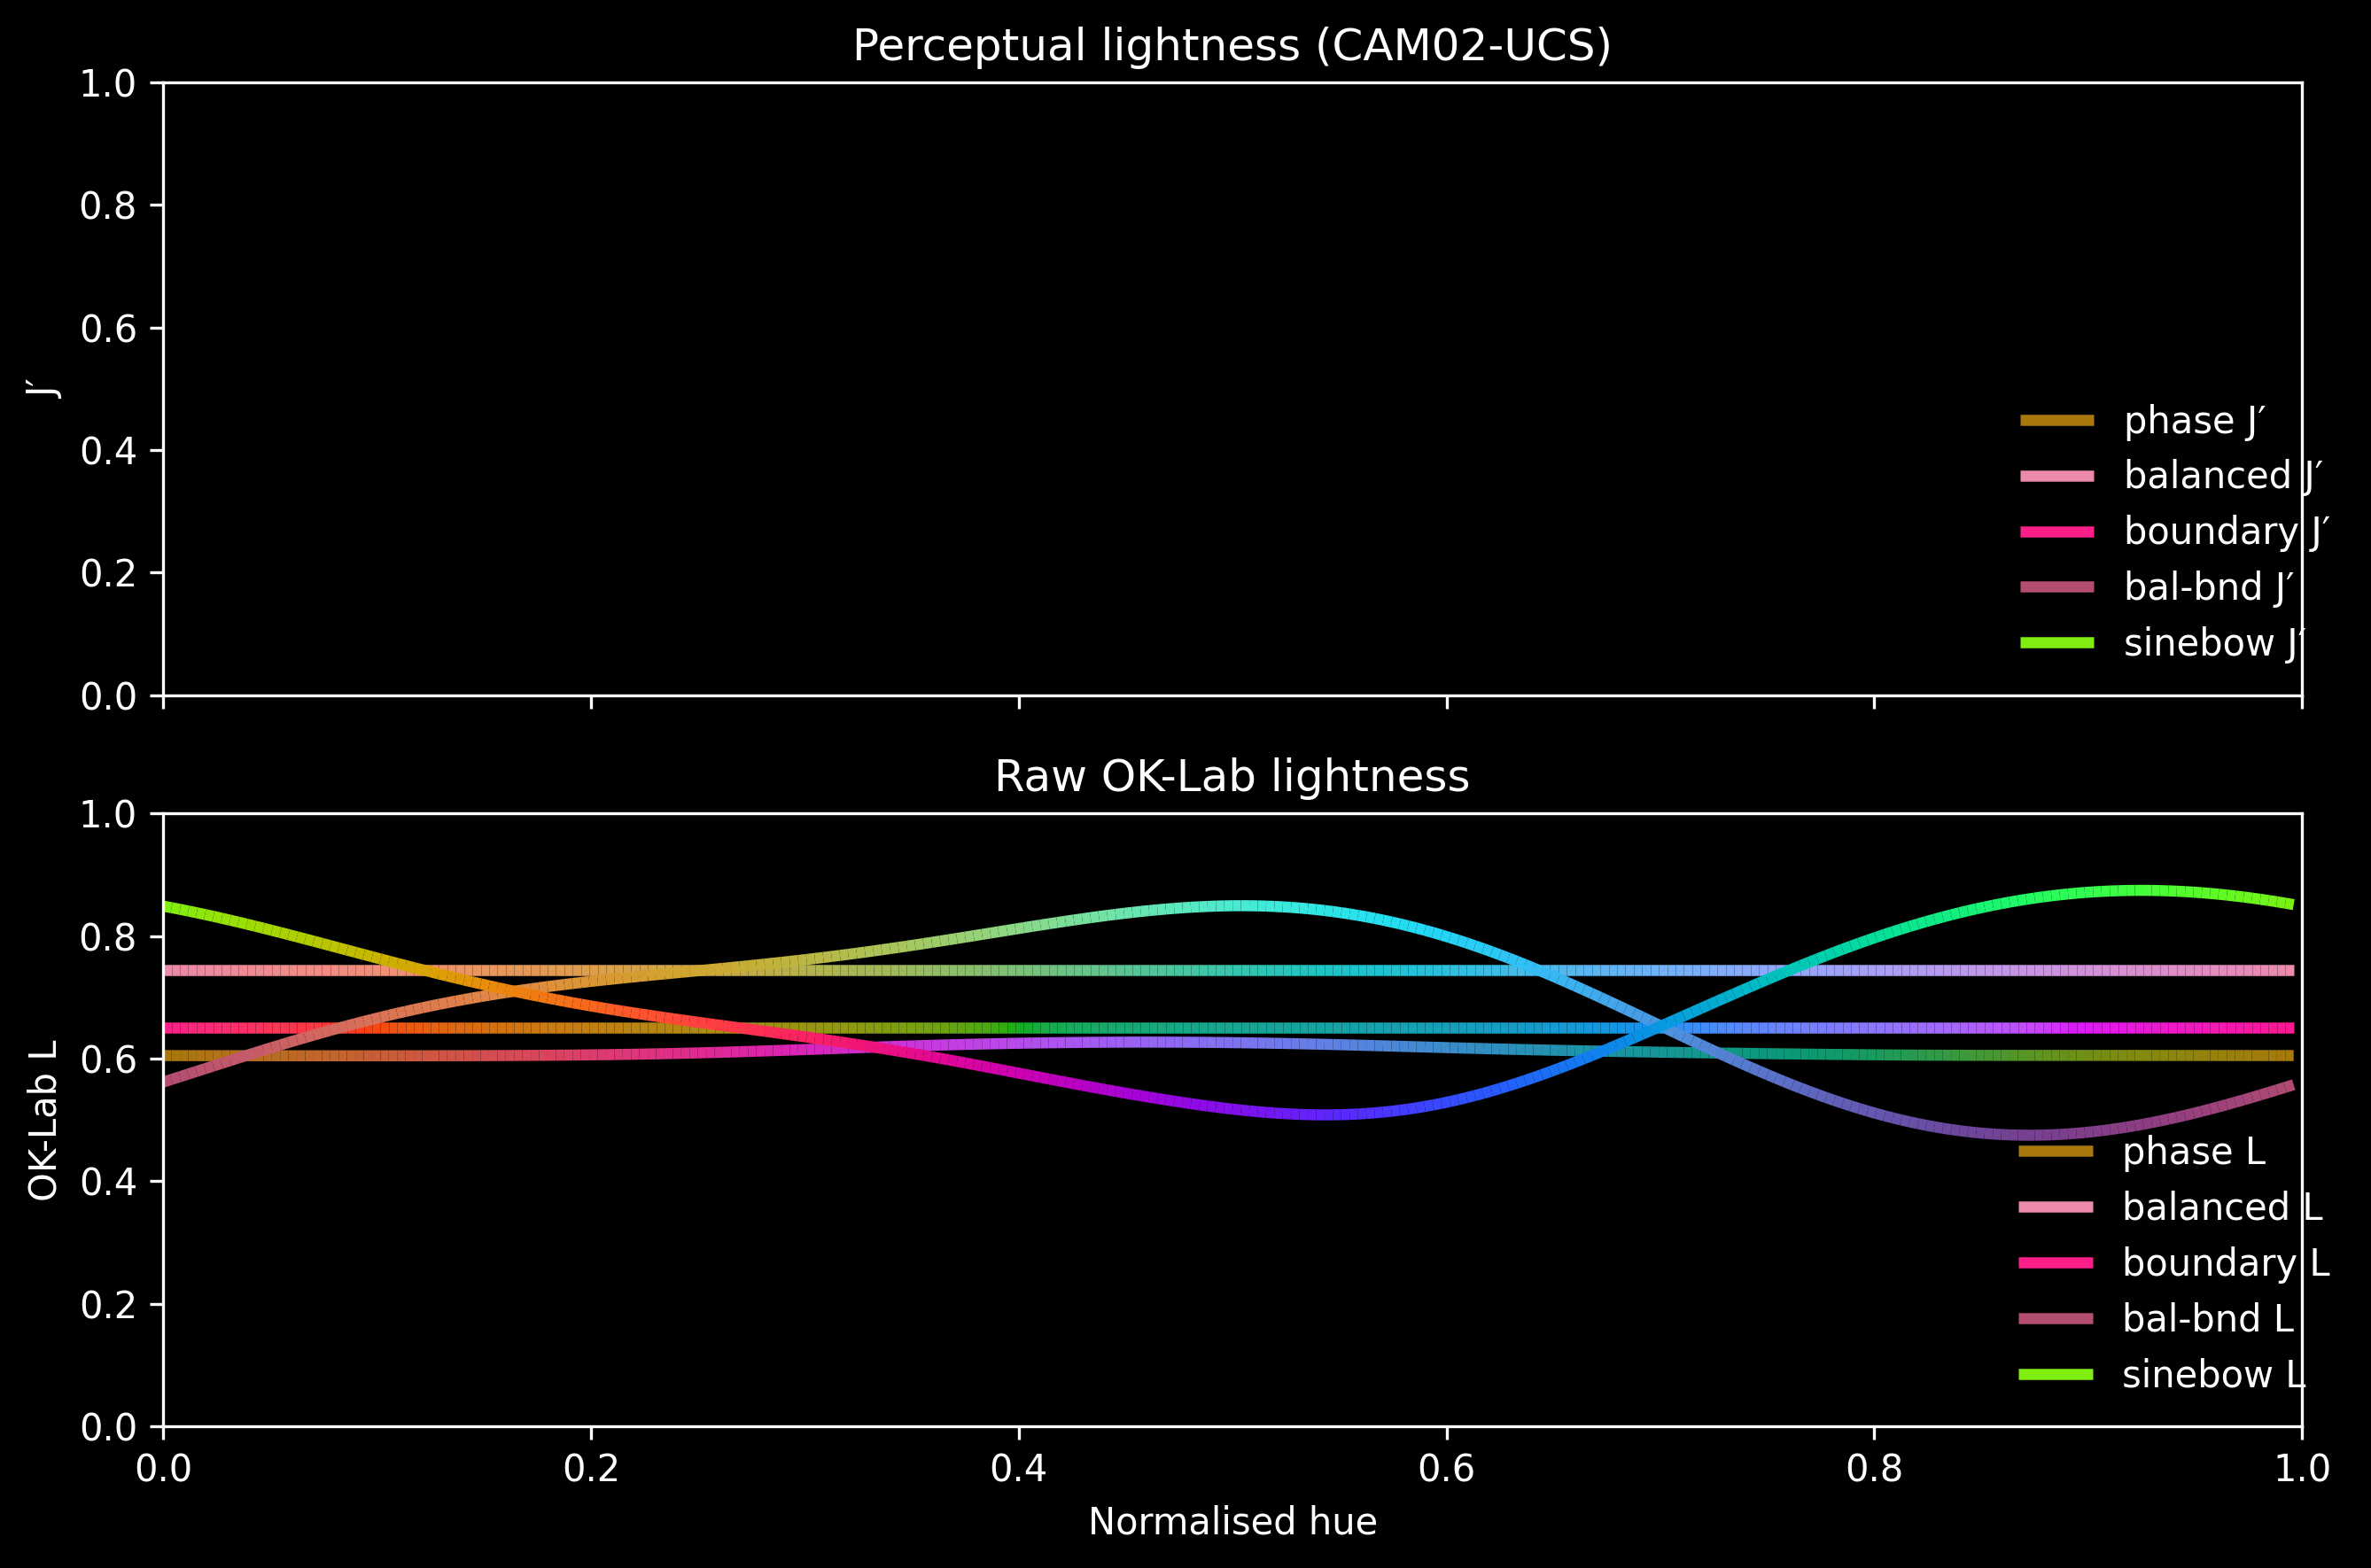

In [ ]:
# ─── helper: sinebow ----------------------------------------------------------
def _sinebow_rgb(t):
    """Dave Green sinebow: sin-waves shifted 120 ° apart, scaled to 0-1."""
    ang = 2*np.pi*t[..., None] + np.array([0, 2*np.pi/3, 4*np.pi/3])
    return (np.sin(ang) + 1)*0.5


# ─── wheel sampler ------------------------------------------------------------
def sample_wheels(N=256, L0=0.65):
    """
    Return every wheel as (N,3) sRGB arrays, in a fixed order:
      0 phase, 1 balanced, 2 boundary, 3 balanced-boundary, 4 sinebow
    """
    t          = np.linspace(0, 1, N, endpoint=False)
    phase_rgb  = np.array([Colormap("cmocean:phase")(float(v)).rgba[:3] for v in t])

    wheel_bal, _, _  = build_balanced_wheel(N)
    wheel_bnd, _     = build_boundary_wheel(N, L0=L0)
    # wheel_bb, _, _   = build_balanced_boundary_wheel(N)          # NEW
    wheel_bb, C0, L_path, L_lo, L_hi =   build_slice_sine_opt_wheel(order=2)
    
    sine_rgb         = _sinebow_rgb(t)

    return phase_rgb, wheel_bal, wheel_bnd, wheel_bb, sine_rgb


# ─── compute J′ and L profiles ------------------------------------------------
def compute_profiles(N=256, L0=0.65, divide_by_mean=False):
    t = np.linspace(0, 1, N, endpoint=False)
    ph, ba, bn, bb, si = sample_wheels(N, L0)

    xyz   = list(map(sRGB_to_XYZ, (ph, ba, bn, bb, si)))
    Jp    = [XYZ_to_CAM02UCS(x)[:, 0] for x in xyz]
    Lab_L = [XYZ_to_Oklab(x)[:, 0]    for x in xyz]

    if divide_by_mean:
        for arr in Jp + Lab_L:
            arr /= arr.mean()

    # flatten lists so caller doesn’t care about grouping
    return (t, (ph, ba, bn, bb, si), Jp, Lab_L)


# ─── plotting ----------------------------------------------------------------
def plot_profiles(divide_by_mean=False):
    t, wheels, Jp_list, L_list = compute_profiles(divide_by_mean=divide_by_mean)
    labels = ["phase", "balanced", "boundary", "bal-bnd", "sinebow"]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

    # – CAM02-UCS J′ –
    for rgb, y, lbl in zip(wheels, Jp_list, labels):
        segs = np.stack([np.column_stack([t, y])[:-1],
                         np.column_stack([t, y])[1:]], axis=1)
        ax1.add_collection(LineCollection(segs, colors=rgb[:-1], lw=3, label=f"{lbl} J′"))
    ax1.set_ylabel("J′"); ax1.set_title("Perceptual lightness (CAM02-UCS)")
    ax1.legend(loc="upper right")

    # – OK-Lab L –
    for rgb, y, lbl in zip(wheels, L_list, labels):
        segs = np.stack([np.column_stack([t, y])[:-1],
                         np.column_stack([t, y])[1:]], axis=1)
        ax2.add_collection(LineCollection(segs, colors=rgb[:-1], lw=3, label=f"{lbl} L"))
    ax2.set_ylabel("OK-Lab L"); ax2.set_xlabel("Normalised hue")
    ax2.set_title("Raw OK-Lab lightness"); ax2.legend(loc="upper right")

    plt.tight_layout(); plt.show()


# Example call
plot_profiles(divide_by_mean=0)